# AWS CodePipeline を使って ML CI/CD パイプラインを作成する

このノートブックは、AWS CodePipeline を使って以下のような CI/CD パイプライン全体を作ります。

- AWS CodeCommit へのファイル変更でパイプラインを実行開始
- AWS Step Functions で作成した、データ準備、モデル学習、モデル評価、後処理のパイプラインを実行
- モデルデプロイ可否を手動承認
- 承認されたらモデルを Amazon SageMaker 推論エンドポイントにデプロイ

**このノートブックでは緩めの権限を持つ IAM Polycy と IAM Role を使用していますが、本番環境では最小限の権限を持つ Policy, Role を作成・使用してください。[IAM Access Analyzer](https://docs.aws.amazon.com/ja_jp/IAM/latest/UserGuide/access-analyzer-policy-generation.html) は、必要な権限のみを持つ Policy の作成をサポートします。**

<img src='architecture.png'>

## このサンプルのファイル構成

```
root
|- docker: 後処理 Lambda 用ファイル一式
|- git-repo-codes: CodeCommit に push するファイル一式。CodeBuild で使用
|- Create-ML-Model-CICD-Pipeline.ipynb: このノートブック。上記アーキテクチャを作成する
|- Dockerfile: ベースコンテナイメージ作成用
```

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AWS-CodePipeline-を使って-ML-CI/CD-パイプラインを作成する" data-toc-modified-id="AWS-CodePipeline-を使って-ML-CI/CD-パイプラインを作成する-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AWS CodePipeline を使って ML CI/CD パイプラインを作成する</a></span><ul class="toc-item"><li><span><a href="#このサンプルのファイル構成" data-toc-modified-id="このサンプルのファイル構成-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>このサンプルのファイル構成</a></span></li><li><span><a href="#環境のセットアップ" data-toc-modified-id="環境のセットアップ-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>環境のセットアップ</a></span><ul class="toc-item"><li><span><a href="#必要なモジュールのインポート" data-toc-modified-id="必要なモジュールのインポート-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>必要なモジュールのインポート</a></span></li><li><span><a href="#ノートブックインスタンスの-IAM-ロールに権限を追加" data-toc-modified-id="ノートブックインスタンスの-IAM-ロールに権限を追加-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>ノートブックインスタンスの IAM ロールに権限を追加</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Amazon-SageMaker-Experiments-の作成" data-toc-modified-id="Amazon-SageMaker-Experiments-の作成-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Amazon SageMaker Experiments の作成</a></span></li><li><span><a href="#Amazon-SageMaker-Model-Package-Group-の作成（Model-Registry-利用準備）" data-toc-modified-id="Amazon-SageMaker-Model-Package-Group-の作成（Model-Registry-利用準備）-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Amazon SageMaker Model Package Group の作成（Model Registry 利用準備）</a></span></li><li><span><a href="#ベースイメージを-Amazon-ECR-に-push" data-toc-modified-id="ベースイメージを-Amazon-ECR-に-push-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>ベースイメージを Amazon ECR に push</a></span></li><li><span><a href="#ML-パイプラインの中の後処理-Lambda-関数の作成" data-toc-modified-id="ML-パイプラインの中の後処理-Lambda-関数の作成-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>ML パイプラインの中の後処理 Lambda 関数の作成</a></span></li><li><span><a href="#評価結果読み出し-Lambda-関数の作成" data-toc-modified-id="評価結果読み出し-Lambda-関数の作成-1.3.5"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>評価結果読み出し Lambda 関数の作成</a></span></li></ul></li><li><span><a href="#AWS-CodeCommit-リポジトリの作成" data-toc-modified-id="AWS-CodeCommit-リポジトリの作成-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>AWS CodeCommit リポジトリの作成</a></span><ul class="toc-item"><li><span><a href="#create_repository()-API-でリポジトリを作成" data-toc-modified-id="create_repository()-API-でリポジトリを作成-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>create_repository() API でリポジトリを作成</a></span></li></ul></li><li><span><a href="#AWS-CodeBuild-プロジェクトの作成" data-toc-modified-id="AWS-CodeBuild-プロジェクトの作成-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>AWS CodeBuild プロジェクトの作成</a></span><ul class="toc-item"><li><span><a href="#Build-Stage-で使用する-IAM-Policy-と-Role-の作成" data-toc-modified-id="Build-Stage-で使用する-IAM-Policy-と-Role-の作成-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Build Stage で使用する IAM Policy と Role の作成</a></span></li><li><span><a href="#create_project()-API-で-Build-Stage-用プロジェクトを作成" data-toc-modified-id="create_project()-API-で-Build-Stage-用プロジェクトを作成-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>create_project() API で Build Stage 用プロジェクトを作成</a></span></li><li><span><a href="#Deploy-Stage-で使用する-IAM-Policy-と-Role-の作成" data-toc-modified-id="Deploy-Stage-で使用する-IAM-Policy-と-Role-の作成-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Deploy Stage で使用する IAM Policy と Role の作成</a></span></li><li><span><a href="#create_project()-API-で-Deploy-Stage-用プロジェクトを作成" data-toc-modified-id="create_project()-API-で-Deploy-Stage-用プロジェクトを作成-1.5.4"><span class="toc-item-num">1.5.4&nbsp;&nbsp;</span>create_project() API で Deploy Stage 用プロジェクトを作成</a></span></li><li><span><a href="#AWS-Step-Functions-用-IAM-Policy-と-Role-の作成" data-toc-modified-id="AWS-Step-Functions-用-IAM-Policy-と-Role-の作成-1.5.5"><span class="toc-item-num">1.5.5&nbsp;&nbsp;</span>AWS Step Functions 用 IAM Policy と Role の作成</a></span></li><li><span><a href="#ML-パイプライン設定ファイルの作成" data-toc-modified-id="ML-パイプライン設定ファイルの作成-1.5.6"><span class="toc-item-num">1.5.6&nbsp;&nbsp;</span>ML パイプライン設定ファイルの作成</a></span></li><li><span><a href="#データ準備用のコンテナイメージ用-Dockerfile-の作成" data-toc-modified-id="データ準備用のコンテナイメージ用-Dockerfile-の作成-1.5.7"><span class="toc-item-num">1.5.7&nbsp;&nbsp;</span>データ準備用のコンテナイメージ用 Dockerfile の作成</a></span></li><li><span><a href="#モデル学習用のコンテナイメージ用-Dockerfile-の作成" data-toc-modified-id="モデル学習用のコンテナイメージ用-Dockerfile-の作成-1.5.8"><span class="toc-item-num">1.5.8&nbsp;&nbsp;</span>モデル学習用のコンテナイメージ用 Dockerfile の作成</a></span></li><li><span><a href="#モデル評価用のコンテナイメージ用-Dockerfile-の作成" data-toc-modified-id="モデル評価用のコンテナイメージ用-Dockerfile-の作成-1.5.9"><span class="toc-item-num">1.5.9&nbsp;&nbsp;</span>モデル評価用のコンテナイメージ用 Dockerfile の作成</a></span></li><li><span><a href="#モデルデプロイ用のコンテナイメージ用-Dockerfile-の作成" data-toc-modified-id="モデルデプロイ用のコンテナイメージ用-Dockerfile-の作成-1.5.10"><span class="toc-item-num">1.5.10&nbsp;&nbsp;</span>モデルデプロイ用のコンテナイメージ用 Dockerfile の作成</a></span></li><li><span><a href="#作成した-CodeBuild-用のファイルを-CodeCommit-に-push" data-toc-modified-id="作成した-CodeBuild-用のファイルを-CodeCommit-に-push-1.5.11"><span class="toc-item-num">1.5.11&nbsp;&nbsp;</span>作成した CodeBuild 用のファイルを CodeCommit に push</a></span></li></ul></li><li><span><a href="#CodePipeline-のパイプライン作成" data-toc-modified-id="CodePipeline-のパイプライン作成-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>CodePipeline のパイプライン作成</a></span><ul class="toc-item"><li><span><a href="#CodePipeline-で使用する-IAM-Policy-と-Role-を作成" data-toc-modified-id="CodePipeline-で使用する-IAM-Policy-と-Role-を作成-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>CodePipeline で使用する IAM Policy と Role を作成</a></span></li><li><span><a href="#create_pipeline()-API-でパイプラインを作成" data-toc-modified-id="create_pipeline()-API-でパイプラインを作成-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>create_pipeline() API でパイプラインを作成</a></span></li></ul></li><li><span><a href="#記録された各種データの確認" data-toc-modified-id="記録された各種データの確認-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>記録された各種データの確認</a></span><ul class="toc-item"><li><span><a href="#Amazon-Experiments-の中を確認" data-toc-modified-id="Amazon-Experiments-の中を確認-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>Amazon Experiments の中を確認</a></span></li><li><span><a href="#Model-Registry-の中を確認" data-toc-modified-id="Model-Registry-の中を確認-1.7.2"><span class="toc-item-num">1.7.2&nbsp;&nbsp;</span>Model Registry の中を確認</a></span></li></ul></li><li><span><a href="#推論エンドポイントの動作確認" data-toc-modified-id="推論エンドポイントの動作確認-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>推論エンドポイントの動作確認</a></span></li><li><span><a href="#[おまけ]-Model-Registry-のモデルパッケージをデプロイ" data-toc-modified-id="[おまけ]-Model-Registry-のモデルパッケージをデプロイ-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>[おまけ] Model Registry のモデルパッケージをデプロイ</a></span></li><li><span><a href="#リソースの削除" data-toc-modified-id="リソースの削除-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>リソースの削除</a></span><ul class="toc-item"><li><span><a href="#Amazon-SageMaker-推論エンドポイントの削除" data-toc-modified-id="Amazon-SageMaker-推論エンドポイントの削除-1.10.1"><span class="toc-item-num">1.10.1&nbsp;&nbsp;</span>Amazon SageMaker 推論エンドポイントの削除</a></span></li><li><span><a href="#CodeCommit,-CodeBuild,-CodePipeline-の削除" data-toc-modified-id="CodeCommit,-CodeBuild,-CodePipeline-の削除-1.10.2"><span class="toc-item-num">1.10.2&nbsp;&nbsp;</span>CodeCommit, CodeBuild, CodePipeline の削除</a></span></li><li><span><a href="#Amazon-ECR-リポジトリの削除" data-toc-modified-id="Amazon-ECR-リポジトリの削除-1.10.3"><span class="toc-item-num">1.10.3&nbsp;&nbsp;</span>Amazon ECR リポジトリの削除</a></span></li><li><span><a href="#Lambda-関数の削除" data-toc-modified-id="Lambda-関数の削除-1.10.4"><span class="toc-item-num">1.10.4&nbsp;&nbsp;</span>Lambda 関数の削除</a></span></li><li><span><a href="#Experiment-の削除" data-toc-modified-id="Experiment-の削除-1.10.5"><span class="toc-item-num">1.10.5&nbsp;&nbsp;</span>Experiment の削除</a></span></li><li><span><a href="#Amazon-SageMaker-Model-Registry-の削除" data-toc-modified-id="Amazon-SageMaker-Model-Registry-の削除-1.10.6"><span class="toc-item-num">1.10.6&nbsp;&nbsp;</span>Amazon SageMaker Model Registry の削除</a></span></li><li><span><a href="#AWS-Step-Functions-ワークフローの削除" data-toc-modified-id="AWS-Step-Functions-ワークフローの削除-1.10.7"><span class="toc-item-num">1.10.7&nbsp;&nbsp;</span>AWS Step Functions ワークフローの削除</a></span></li><li><span><a href="#IAM-Role-と-Policy-の削除" data-toc-modified-id="IAM-Role-と-Policy-の削除-1.10.8"><span class="toc-item-num">1.10.8&nbsp;&nbsp;</span>IAM Role と Policy の削除</a></span></li><li><span><a href="#Amazon-S3-バケットの削除" data-toc-modified-id="Amazon-S3-バケットの削除-1.10.9"><span class="toc-item-num">1.10.9&nbsp;&nbsp;</span>Amazon S3 バケットの削除</a></span></li></ul></li></ul></li></ul></div>

## 環境のセットアップ

このノートブックを実行するのに必要なライブラリをインストールします。

In [1]:
# Import the latest sagemaker, stepfunctions and boto3 SDKs
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install -qU awscli boto3 "sagemaker>=2.0.0"
!{sys.executable} -m pip install -qU "stepfunctions==2.3.0"
!{sys.executable} -m pip install sagemaker-experiments
!{sys.executable} -m pip show sagemaker

このサンプルノートブックは長いので、実行したいセルにアクセスしやすいよう Table of Contents を作成する拡張機能をインストールすると便利です。以下のセルを実行したあと、このノートブックを開いているブラウザのタブをリロードすると Table of Contents の拡張機能が使えるようになります。

In [2]:
%%sh
pip install jupyter_contrib_nbextensions
jupyter contrib nbextension install --user
jupyter nbextension enable toc2/main

### 必要なモジュールのインポート

同一アカウントで複数の方が同時にこのノートブックを実行する場合は、以下のセルの一番下の行の `user_name` に各自のお名前を設定してください。

In [3]:
import boto3
from datetime import datetime
from dateutil import tz
import json
import os
import sagemaker
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from stepfunctions.workflow import Workflow
from time import sleep

JST = tz.gettz('Asia/Tokyo')
timestamp = datetime.now(JST).strftime('%Y%m%d-%H%M%S')

sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
account_id = boto3.client('sts').get_caller_identity().get('Account')

codecommit_client = boto3.client('codecommit', region_name=region)
codebuild_client = boto3.client('codebuild', region_name=region)
codepipeline_client = boto3.client('codepipeline', region_name=region)
iam_client = boto3.client('iam', region_name=region)
s3_client = boto3.client('s3', region_name=region)
lambda_client = boto3.client('lambda', region_name=region)
ecr_client = boto3.client('ecr', region_name=region)
sagemaker_client = boto3.client('sagemaker', region_name=region)

以下のセルを実行して、各種リソース名を作成します。

In [4]:
project_name = 'mlops-pipeline'
user_name = 'sample2'
bucket_name = project_name + '-' + user_name + '-' + timestamp
code_repository_name = project_name + '-code-' + user_name
codebuild_project_name = project_name + '-codebuild-' + user_name
codebuild_deploy_project_name = project_name + '-codebuild-deploy-' + user_name
codepipeline_name = project_name + '-codepipeline-' + user_name
mlworkflow_name = project_name + '-flow-' + user_name
postprocess_name = project_name + '-post-' + user_name
experiment_name = project_name + '-exp-' + user_name
model_package_group_name = project_name + '-mpg-' + user_name
lambda_read_metrics_function_name = project_name + '-read-metrics-' + user_name
role_name_list = []
policy_arn_list = []

IAM 関連の関数を作成します。

In [5]:
def get_policy_arn(policy_name):
    next_token = ''
    while True:
        if next_token == '':
            response = iam_client.list_policies(Scope='Local')
        else:
            response = iam_client.list_policies(Scope='Local', Marker=next_token)
        for content in response['Policies']:
            if policy_name == content['PolicyName']:
                return content['Arn']
        if 'Marker' in response:
            next_token = response['Marker']
        else:
            break

    return ''


def get_role_arn(role_name):
    next_token = ''
    while True:
        if next_token == '':
            response = iam_client.list_roles()
        else:
            response = iam_client.list_roles(Marker=next_token)
        for content in response['Roles']:
            if role_name == content['RoleName']:
                return content['Arn']
        if 'Marker' in response:
            next_token = response['Marker']
        else:
            break

    return ''


def create_role(role_name, assume_role_policy):
    try:
        response = iam_client.create_role(
            Path = '/service-role/',
            RoleName = role_name,
            AssumeRolePolicyDocument = json.dumps(assume_role_policy),
            MaxSessionDuration=3600*12 # 12 hours
        )
        role_arn = response['Role']['Arn']
    except Exception as ex:
        if "EntityAlreadyExists" in str(ex):
            detach_role_policies(role_name)
            response = iam_client.delete_role(
                RoleName = role_name,
            )
            response = iam_client.create_role(
                Path = '/service-role/',
                RoleName = role_name,
                AssumeRolePolicyDocument = json.dumps(assume_role_policy),
                MaxSessionDuration=3600*12 # 12 hours
            )
            role_arn = response['Role']['Arn']
    sleep(10)
    return role_arn


def create_policy(policy_name, inline_policy):
    try:
        response = iam_client.create_policy(
            PolicyName=policy_name,
            PolicyDocument=json.dumps(inline_policy),
        )
        policy_arn = response['Policy']['Arn']
    except Exception as ex:
        if "EntityAlreadyExists" in str(ex):
            response = iam_client.delete_policy(
                PolicyArn=get_policy_arn(policy_name)
            )
            response = iam_client.create_policy(
                PolicyName=policy_name,
                PolicyDocument=json.dumps(inline_policy),
            )
            policy_arn = response['Policy']['Arn']
    policy_arn_list.append(policy_arn)
    sleep(10)
    return policy_arn


def create_policy_role(policy_name, inline_policy, role_name, assume_role_policy, policy_list=[]):

    role_arn = create_role(role_name, assume_role_policy)
    policy_arn = create_policy(policy_name, inline_policy)

    sleep(5)
    response = iam_client.attach_role_policy(
        RoleName=role_name,
        PolicyArn=policy_arn
    )

    for p in policy_list:
        response = iam_client.attach_role_policy(
            RoleName=role_name,
            PolicyArn='arn:aws:iam::aws:policy/' + p
        )

    role_name_list.append(role_name)
    policy_arn_list.append(policy_arn)
    sleep(10)

### ノートブックインスタンスの IAM ロールに権限を追加

以下の手順を実行して、ノートブックインスタンスに紐づけられた IAM ロールに、AWS Step Functions のワークフローを作成して実行するための権限と Amazon ECR にイメージを push するための権限を追加してください。


1. [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/) を開く
1. **ノートブックインスタンス** を開いて現在使用しているノートブックインスタンスを選択する
1. **アクセス許可と暗号化** の部分に表示されている IAM ロールへのリンクをクリックする
1. IAM ロールの ARN は後で使用するのでメモ帳などにコピーしておく
1. **ポリシーをアタッチします** をクリックして `IAMFullAccess` を検索する
1. `IAMFullAccess` の横のチェックボックスをオンにする
1. **ポリシーのアタッチ** をクリックする


もしこのノートブックを SageMaker のノートブックインスタンス以外で実行している場合、その環境で AWS CLI 設定を行ってください。詳細は [Configuring the AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html) をご参照ください。

In [6]:
policy_list = ['AWSCodePipeline_FullAccess', 'AmazonEC2ContainerRegistryFullAccess',
               'AWSLambda_FullAccess', 'AWSCodeCommitFullAccess',
              'AWSCodeBuildAdminAccess', 'AWSStepFunctionsFullAccess']

inline_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "VisualEditor0",
            "Effect": "Allow",
            "Action": "s3:PutEncryptionConfiguration",
            "Resource": "arn:aws:s3:::" + bucket_name
        }
    ]
}

sagemaker_policy_name = project_name + '-' + user_name + '-policy'
sagemaker_policy_arn = get_policy_arn(sagemaker_policy_name)

if len(sagemaker_policy_arn) > 0:
    response = iam_client.detach_role_policy(
        RoleName=role.split('/')[2],
        PolicyArn=sagemaker_policy_arn
    )
sagemaker_policy_arn = create_policy(sagemaker_policy_name, inline_policy)
sleep(5)

response = iam_client.attach_role_policy(
        RoleName=role.split('/')[2],
        PolicyArn=sagemaker_policy_arn
    )

for l in policy_list:
    response = iam_client.attach_role_policy(
        RoleName=role.split('/')[2],
        PolicyArn='arn:aws:iam::aws:policy/' + l
    )
sleep(10)

以下のセルを実行して、このサンプルでファイルの保存に使用するバケットを新規作成します。

In [7]:
if region == 'us-east-1':
    response = s3_client.create_bucket(Bucket=bucket_name)
else:
    location = {'LocationConstraint': region}
    response = s3_client.create_bucket(Bucket=bucket_name,
                                       CreateBucketConfiguration=location)
sleep(10)
response = s3_client.put_bucket_encryption(
    Bucket=bucket_name,
    ServerSideEncryptionConfiguration={
        'Rules': [
            {
                'ApplyServerSideEncryptionByDefault': {
                    'SSEAlgorithm': 'AES256',
                },
            },
        ]
    },
)

作成したバケットの暗号化を有効化します。

In [8]:
response = s3_client.put_bucket_encryption(
    Bucket=bucket_name,
    ServerSideEncryptionConfiguration={
        'Rules': [
            {
                'ApplyServerSideEncryptionByDefault': {
                    'SSEAlgorithm': 'AES256',
                },
            },
        ]
    },
)

## Setup
### Amazon SageMaker Experiments の作成

In [9]:
# create the experiment if it doesn't exist
try:
    experiment_evaluate = Experiment.load(experiment_name=experiment_name)
except Exception as ex:
    if "ResourceNotFound" in str(ex):
        experiment_evaluate = Experiment.create(
            experiment_name=experiment_name, 
            description="model evaluation", 
            sagemaker_boto_client=boto3.client('sagemaker'))
    else:
        print(ex)

print(experiment_evaluate.experiment_name)

mlops-pipeline-exp-sample2


### Amazon SageMaker Model Package Group の作成（Model Registry 利用準備）

In [10]:
model_package_group_input_dict = {
    "ModelPackageGroupName": model_package_group_name,
    "ModelPackageGroupDescription": "This is MLOps demo",
}

try:
    create_model_pacakge_group_response = sagemaker_client.create_model_package_group(
        **model_package_group_input_dict
    )
    model_package_group_arn = create_model_pacakge_group_response["ModelPackageGroupArn"]
except Exception as e:
    model_package_group_arn = f'arn:aws:sagemaker:{region}:{account_id}:model-package-group/{model_package_group_name}'
print(f"ModelPackageGroup Arn : {model_package_group_arn}")

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:021269156472:model-package-group/mlops-pipeline-mpg-sample2


### ベースイメージを Amazon ECR に push

試行錯誤の中で何度もコンテナイメージのビルドを繰り返していると、Docker Hub からベースイメージを pull できなくなることがあります。そこで、はじめにベースイメージをビルドして Amazon ECR に push しておき、そちらを今後ベースイメージとして使用します。

In [11]:
def build_and_push_image(repo_name, docker_path, extra_accounts=[], tag = ':latest'):
    uri_suffix = 'amazonaws.com'
    repository_uri = '{}.dkr.ecr.{}.{}/{}'.format(account_id, region, uri_suffix, repo_name + tag)

    !docker build -t $repo_name $docker_path
    for a in extra_accounts:
        !aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {a}.dkr.ecr.{region}.amazonaws.com
    !aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account_id}.dkr.ecr.{region}.amazonaws.com
    !aws ecr create-repository --repository-name $repo_name
    !docker tag {repo_name + tag} $repository_uri
    !docker push $repository_uri
    return repository_uri

In [12]:
base_repository_uri = build_and_push_image(project_name + '-base-' + user_name, '.')

Sending build context to Docker daemon   88.5MB
Step 1/1 : FROM python:3.8-slim-buster
 ---> cf7c1a2d6198
Successfully built cf7c1a2d6198
Successfully tagged mlops-pipeline-base-sample2:latest
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
{
    "repository": {
        "repositoryArn": "arn:aws:ecr:us-east-1:021269156472:repository/mlops-pipeline-base-sample2",
        "registryId": "021269156472",
        "repositoryName": "mlops-pipeline-base-sample2",
        "repositoryUri": "021269156472.dkr.ecr.us-east-1.amazonaws.com/mlops-pipeline-base-sample2",
        "createdAt": 1644394348.0,
        "imageTagMutability": "MUTABLE",
        "imageScanningConfiguration": {
            "scanOnPush": false
        },
        "encryptionConfiguration": {
            "encryptionType": "AES256"
        }


### ML パイプラインの中の後処理 Lambda 関数の作成

モデルの評価ジョブでの評価結果をもとに、Lambda 関数で後処理を行います。後処理としては例えば、Slack にモデルの評価結果をポストしたり、別の Workflow を起動したりなどが考えられます。このノートブックでは、評価結果に応じて表示するテキストの内容を変えています。

実行環境やソースコードが入ったコンテナイメージを Lambda にデプロイします。このノートブックでは、Experiment で管理されている情報を取得するために `sagemaker.analytics.ExperimentAnalytics` を使用するため、必要なライブラリが入ったコンテナを使って Lambda 関数を実行します。

In [13]:
dockerfile_name = 'docker/postprocess/Dockerfile'

dockerfile_code = f"""FROM {base_repository_uri}

# Include global arg in this stage of the build
ARG FUNCTION_DIR="/function"

COPY requirements.txt .
RUN pip3 install --upgrade pip
RUN pip3 install -qU -r requirements.txt

# Copy function code
RUN mkdir -p $FUNCTION_DIR
COPY app/ $FUNCTION_DIR/

# Set working directory to function root directory
WORKDIR $FUNCTION_DIR


ENTRYPOINT [ "/usr/local/bin/python", "-m", "awslambdaric" ]
CMD [ "app.handler" ]
"""

with open(dockerfile_name, 'w') as f:
    f.write(dockerfile_code)

In [14]:
lambda_repository_uri = build_and_push_image(project_name + '-lambda-' + user_name, 'docker/postprocess')

Sending build context to Docker daemon  6.144kB
Step 1/10 : FROM 021269156472.dkr.ecr.us-east-1.amazonaws.com/mlops-pipeline-base-sample2:latest
 ---> cf7c1a2d6198
Step 2/10 : ARG FUNCTION_DIR="/function"
 ---> Using cache
 ---> 66525098ef68
Step 3/10 : COPY requirements.txt .
 ---> Using cache
 ---> d002a2fa5069
Step 4/10 : RUN pip3 install --upgrade pip
 ---> Using cache
 ---> 490ebf473786
Step 5/10 : RUN pip3 install -qU -r requirements.txt
 ---> Using cache
 ---> 54fc44ed5190
Step 6/10 : RUN mkdir -p $FUNCTION_DIR
 ---> Using cache
 ---> 94f45801e94a
Step 7/10 : COPY app/ $FUNCTION_DIR/
 ---> Using cache
 ---> 4eafb8a12521
Step 8/10 : WORKDIR $FUNCTION_DIR
 ---> Using cache
 ---> edfa9e14261c
Step 9/10 : ENTRYPOINT [ "/usr/local/bin/python", "-m", "awslambdaric" ]
 ---> Using cache
 ---> 80fbfe9636c0
Step 10/10 : CMD [ "app.handler" ]
 ---> Using cache
 ---> 7bdb7e35cbc9
Successfully built 7bdb7e35cbc9
Successfully tagged mlops-pipeline-lambda-sample2:latest
WARNING! Your password 

In [15]:
import boto3
import json


def detach_role_policies(role_name):
    response = iam_client.list_attached_role_policies(
        RoleName=role_name,
    )
    policies = response['AttachedPolicies']

    for p in policies:
        response = iam_client.detach_role_policy(
            RoleName=role_name,
            PolicyArn=p['PolicyArn']
        )

        
def function_exists(function_name):
    next_token = ''
    while True:
        if next_token == '':
            response = lambda_client.list_functions()
        else:
            response = lambda_client.list_functions(Marker=next_token)
        for content in response['Functions']:
            if function_name == content['FunctionName']:
                return True
        if 'NextMarker' in response:
            next_token = response['NextMarker']
        else:
            break

    return False


def create_container_lambda_function(function_name, image_uri, role_arn):

    if function_exists(function_name):
        response = lambda_client.delete_function(
            FunctionName=function_name,
        )
        sleep(10)

    response = lambda_client.create_function(
        FunctionName=function_name,
        Role=role_arn,
        Code={
            'ImageUri':image_uri
        },
        Timeout=60*5, # 5 minutes
        MemorySize=128, # 128 MB
        Publish=True,
        PackageType='Image',
    )

In [16]:
lambda_policy_name = postprocess_name + '-policy'
lambda_role_name = postprocess_name + '-role'

inline_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "VisualEditor0",
            "Effect": "Allow",
            "Action": "sagemaker:Search",
            "Resource": "*"
        },
        {
            'Effect': 'Allow',
            'Action': 'logs:CreateLogGroup',
            'Resource': f'arn:aws:logs:{region}:{account_id}:*'
        },
        {
            'Effect': 'Allow',
            'Action': [
                'logs:CreateLogStream',
                'logs:PutLogEvents'
            ],
            'Resource': [
                f'arn:aws:logs:{region}:{account_id}:log-group:/aws/lambda/{postprocess_name}:*'
            ]
        }
    ]
}

assume_role_policy = {
  "Version": "2012-10-17",
  "Statement": [{"Sid": "","Effect": "Allow","Principal": {"Service":"lambda.amazonaws.com"},"Action": "sts:AssumeRole"}]
}

create_policy_role(lambda_policy_name, inline_policy,
                   lambda_role_name, assume_role_policy)
lambda_role_arn = iam_client.get_role(RoleName=lambda_role_name)['Role']['Arn']
sleep(10) # wait until IAM is created
create_container_lambda_function(postprocess_name, lambda_repository_uri, lambda_role_arn)

### 評価結果読み出し Lambda 関数の作成

In [17]:
def create_lambda_function(function_name, file_name, role_arn):

    with open(file_name+'.zip', 'rb') as f:
        zip_data = f.read()
        
    if function_exists(function_name):
        response = lambda_client.update_function_code(
            FunctionName=function_name,
            ZipFile=zip_data,
            Publish=True,
        )
    else:
        response = lambda_client.create_function(
            FunctionName=function_name,
            Role=role_arn,
            Handler=file_name+'.lambda_handler',
            Runtime='python3.9',
            Code={
                'ZipFile':zip_data
            },
            Timeout=60*5, # 5 minutes
            MemorySize=128, # 128 MB
            Publish=True,
            PackageType='Zip',
        )
    

In [18]:
lambda_read_metrics_policy_name = lambda_read_metrics_function_name + '-policy'
lambda_read_metrics_role_name = lambda_read_metrics_function_name + '-role'

inline_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "VisualEditor0",
            "Effect": "Allow",
            "Action": "codepipeline:PutJobSuccessResult",
            "Resource": "*"
        },
        {
            'Effect': 'Allow',
            'Action': 'logs:CreateLogGroup',
            'Resource': f'arn:aws:logs:{region}:{account_id}:*'
        },
        {
            'Effect': 'Allow',
            'Action': [
                'logs:CreateLogStream',
                'logs:PutLogEvents'
            ],
            'Resource': [
                f'arn:aws:logs:{region}:{account_id}:log-group:/aws/lambda/{lambda_read_metrics_function_name}:*'
            ]
        }
    ]
}

assume_role_policy = {
  "Version": "2012-10-17",
  "Statement": [{"Sid": "","Effect": "Allow","Principal": {"Service":"lambda.amazonaws.com"},"Action": "sts:AssumeRole"}]
}

policy_list=['AmazonS3ReadOnlyAccess',
             'AmazonS3FullAccess']

create_policy_role(lambda_read_metrics_policy_name, inline_policy,
                   lambda_read_metrics_role_name, assume_role_policy, policy_list=policy_list)
lambda_read_metrics_role_arn = iam_client.get_role(RoleName=lambda_read_metrics_role_name)['Role']['Arn']
sleep(10) # wait until IAM is created

import zipfile
file_name = 'read_metrics'
with zipfile.ZipFile(file_name+'.zip', 'w', compression=zipfile.ZIP_DEFLATED) as new_zip:
    new_zip.write(file_name+'.py')

create_lambda_function(lambda_read_metrics_function_name, file_name, lambda_read_metrics_role_arn)

## AWS CodeCommit リポジトリの作成

### create_repository() API でリポジトリを作成

API の詳細は[こちらのドキュメント](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/codecommit.html#CodeCommit.Client.create_repository) をご参照ください。

In [19]:
response = codecommit_client.create_repository(
    repositoryName=code_repository_name,
    repositoryDescription='sample repository',
    tags={
        'owner': user_name
    }
)

学習パイプラインを作成するためのコード一式を、作成したリポジトリに push します。

In [20]:
%%sh -s $code_repository_name $region
echo $1
rm -rf $1
git clone https://git-codecommit.$2.amazonaws.com/v1/repos/$1
cd $1
git config --global user.name $user_name
git config --global user.email you@example.com
git checkout -b main
cp -r ../git-repo-codes/* ./
# touch readme.md
git add .
git commit -m "first commit"
git push --set-upstream origin main

mlops-pipeline-code-sample2
[main (root-commit) 82b89a3] first commit
 18 files changed, 1217 insertions(+)
 create mode 100644 buildspec-deploy.yml
 create mode 100644 buildspec.yml
 create mode 100644 deploy.py
 create mode 100644 ml-pipeline/data-preparation/preprocessing.py
 create mode 100644 ml-pipeline/data-preparation/requirements.txt
 create mode 100644 ml-pipeline/ecr-regist-images.sh
 create mode 100644 ml-pipeline/inference/requirements.txt
 create mode 100644 ml-pipeline/model-evaluation/evaluation.py
 create mode 100644 ml-pipeline/model-evaluation/requirements.txt
 create mode 100644 ml-pipeline/train/inference.py
 create mode 100644 ml-pipeline/train/requirements.txt
 create mode 100644 ml-pipeline/train/train.py
 create mode 100644 pipeline.py
 create mode 100644 readme.md
 create mode 100644 requirements-deploy.txt
 create mode 100644 requirements.txt
 create mode 100644 setenv.py
 create mode 100644 setenv.sh
Branch 'main' set up to track remote branch 'main' from 'o

Cloning into 'mlops-pipeline-code-sample2'...
Switched to a new branch 'main'
To https://git-codecommit.us-east-1.amazonaws.com/v1/repos/mlops-pipeline-code-sample2
 * [new branch]      main -> main


## AWS CodeBuild プロジェクトの作成

### Build Stage で使用する IAM Policy と Role の作成

以下のセルを実行して、CodeBuild が使用する IAM Policy と Role を作成します。

In [21]:
inline_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "iam:PassRole"
            ],
            "Effect": "Allow",
            "Resource": "*"
        }
    ]
}

assume_role_policy = {
          "Version": "2012-10-17",
          "Statement": [{"Sid": "","Effect": "Allow","Principal": {"Service":"codebuild.amazonaws.com"},"Action": "sts:AssumeRole"}]
        }

codebuild_policy_name = codebuild_project_name + '-policy'
codebuild_role_name = codebuild_project_name + '-role'

create_policy_role(codebuild_policy_name, inline_policy,
                   codebuild_role_name, assume_role_policy,
                   policy_list=['AmazonEC2ContainerRegistryFullAccess',
                       'AmazonS3FullAccess',
                       'AWSCodeBuildDeveloperAccess',
                       'AWSStepFunctionsFullAccess',
                       'CloudWatchLogsFullAccess',
                       'AWSLambda_FullAccess'])

### create_project() API で Build Stage 用プロジェクトを作成

API の詳細は [こちらのドキュメント](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/codebuild.html#CodeBuild.Client.create_project) をご参照ください。

In [22]:
codebuild_role_arn = get_role_arn(codebuild_role_name)

response = codebuild_client.create_project(
    name=codebuild_project_name,
    description='sample project',
    source={
        'type': 'CODEPIPELINE',
        'insecureSsl': False,
    },
    artifacts={
        'type': 'CODEPIPELINE',
        'encryptionDisabled': False,
    },
    cache={
        'type': 'LOCAL',
        'modes': [
            'LOCAL_DOCKER_LAYER_CACHE',
        ]
    },
    environment={
        'type': 'LINUX_CONTAINER',
        'image': 'aws/codebuild/standard:5.0',
        'computeType': 'BUILD_GENERAL1_MEDIUM',
        'privilegedMode': True,
        'imagePullCredentialsType': 'CODEBUILD'
    },
    serviceRole=codebuild_role_arn,
    timeoutInMinutes=120,
    queuedTimeoutInMinutes=120,
#     encryptionKey='string',
    tags=[
        {
            'key': 'owner',
            'value': user_name
        },
    ],
    badgeEnabled=False,
    logsConfig={
        'cloudWatchLogs': {
            'status': 'ENABLED',
        },
        's3Logs': {
            'status': 'ENABLED',
            'location': os.path.join(bucket_name, 'build-log'),
            'encryptionDisabled': False,
            'bucketOwnerAccess': 'READ_ONLY'
        }
    },
)

### Deploy Stage で使用する IAM Policy と Role の作成

In [23]:
inline_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "iam:PassRole"
            ],
            "Effect": "Allow",
            "Resource": "*"
        }
    ]
}

assume_role_policy = {
          "Version": "2012-10-17",
          "Statement": [{"Sid": "","Effect": "Allow","Principal": {"Service":"codebuild.amazonaws.com"},"Action": "sts:AssumeRole"}]
        }

codebuild_deploy_policy_name = codebuild_deploy_project_name + '-policy'
codebuild_deploy_role_name = codebuild_deploy_project_name + '-role'

create_policy_role(codebuild_deploy_policy_name, inline_policy,
                   codebuild_deploy_role_name, assume_role_policy,
                   policy_list=['AmazonEC2ContainerRegistryFullAccess',
                       'AmazonS3FullAccess',
                       'AWSCodeBuildDeveloperAccess',
                       'AmazonSageMakerFullAccess',
                       'CloudWatchLogsFullAccess',
                       'AWSCodePipelineReadOnlyAccess'])

### create_project() API で Deploy Stage 用プロジェクトを作成

In [24]:
codebuild_deploy_role_arn = get_role_arn(codebuild_deploy_role_name)

response = codebuild_client.create_project(
    name=codebuild_deploy_project_name,
    description='sample deploy project',
    source={
        'type': 'CODEPIPELINE',
        'buildspec': 'buildspec-deploy.yml',
        'insecureSsl': False,
    },
    artifacts={
        'type': 'CODEPIPELINE',
        'encryptionDisabled': False,
    },
    cache={
        'type': 'LOCAL',
#         'location': 'string',
        'modes': [
            'LOCAL_DOCKER_LAYER_CACHE',
        ]
    },
    environment={
        'type': 'LINUX_CONTAINER',
        'image': 'aws/codebuild/standard:5.0',
        'computeType': 'BUILD_GENERAL1_MEDIUM',
        'privilegedMode': True,
        'imagePullCredentialsType': 'CODEBUILD'
    },
    serviceRole=codebuild_deploy_role_arn,
    timeoutInMinutes=120,
    queuedTimeoutInMinutes=120,
#     encryptionKey='string',
    tags=[
        {
            'key': 'owner',
            'value': user_name
        },
    ],
    badgeEnabled=False,
    logsConfig={
        'cloudWatchLogs': {
            'status': 'ENABLED',
#             'groupName': 'string',
#             'streamName': 'string'
        },
        's3Logs': {
            'status': 'ENABLED',
            'location': os.path.join(bucket_name, 'build-log'),
            'encryptionDisabled': False,
            'bucketOwnerAccess': 'READ_ONLY'
        }
    },
)

### AWS Step Functions 用 IAM Policy と Role の作成

In [25]:
import json

step_functions_policy_name = project_name + '-stepfunctions-' + user_name + '-policy'
step_functions_role_name = project_name + '-stepfunctions-' + user_name + '-role'
inline_policy ={
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "VisualEditor0",
            "Effect": "Allow",
            "Action": [
                "events:PutTargets",
                "events:DescribeRule",
                "events:PutRule"
            ],
            "Resource": [
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTrainingJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTransformJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTuningJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForECSTaskRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForBatchJobsRule"
            ]
        },
        {
            "Sid": "VisualEditor1",
            "Effect": "Allow",
            "Action": "iam:PassRole",
            "Resource": role,
            "Condition": {
                "StringEquals": {
                    "iam:PassedToService": "sagemaker.amazonaws.com"
                }
            }
        },
        {
            "Sid": "VisualEditor2",
            "Effect": "Allow",
            "Action": [
                "ecs:DescribeTasks",
                "ecs:RunTask",
                "ecs:StopTask",
                "lambda:InvokeFunction",
                "sagemaker:CreateEndpoint",
                "sagemaker:CreateEndpointConfig",
                "sagemaker:CreateHyperParameterTuningJob",
                "sagemaker:CreateModel",
                "sagemaker:CreateProcessingJob",
                "sagemaker:CreateTrainingJob",
                "sagemaker:CreateTransformJob",
                "sagemaker:DeleteEndpoint",
                "sagemaker:DeleteEndpointConfig",
                "sagemaker:DescribeHyperParameterTuningJob",
                "sagemaker:DescribeProcessingJob",
                "sagemaker:DescribeTrainingJob",
                "sagemaker:DescribeTransformJob",
                "sagemaker:ListProcessingJobs",
                "sagemaker:ListTags",
                "sagemaker:StopHyperParameterTuningJob",
                "sagemaker:StopProcessingJob",
                "sagemaker:StopTrainingJob",
                "sagemaker:StopTransformJob",
                "sagemaker:UpdateEndpoint",
                "sns:Publish",
                "sqs:SendMessage"
            ],
            "Resource": "*"
        }
    ]
}

assume_role_policy = {
      "Version": "2012-10-17",
      "Statement": [{"Sid": "","Effect": "Allow","Principal": {"Service":"states.amazonaws.com"},"Action": "sts:AssumeRole"}]
    }

create_policy_role(step_functions_policy_name, inline_policy,
                   step_functions_role_name, assume_role_policy,
                   ['CloudWatchEventsFullAccess'])

### ML パイプライン設定ファイルの作成
ML パイプラインの設定値が記載された flow.yml を作成します。この設定ファイルには、学習データが保存されている Amazon S3 パスや機械学習アルゴリズムのハイパーパラメタなどの、機械学習モデルを学習。評価するために必要な情報が記載されています。パラメタを変えて CI/CD パイプラインを実行したい場合はこの flow.yml ファイルを更新して CodeCommit に push することで CodePipeline のパイプラインが開始します。

In [26]:
step_functions_role_arn = get_role_arn(step_functions_role_name)
filepath = os.path.join(code_repository_name, 'flow.yml')

flow_yml={f"""config:
  user-name: {user_name}
  region: {region}
  codepipeline-name: {codepipeline_name}
  job-name-prefix: {mlworkflow_name}
  image-name-prefix: {mlworkflow_name}
  sfn-workflow-name: {mlworkflow_name}
  sagemaker-experiment-name: {experiment_name}
  sfn-role-arn: {step_functions_role_arn}
  sagemaker-role: {role}
  framework-version: 1.9.1
  model-package-group-arn: {model_package_group_arn}
preprocess:
  image-repo-name: {project_name}-preprocess-{user_name}
  input-data-path: s3://fast-ai-imageclas/mnist_png.tgz
  output-data-path: s3://{bucket_name}/data/PennFudanPed_Augmented
train:
  image-repo-name: {project_name}-train-{user_name}
  output-path: s3://{bucket_name}/train
  hyperparameters:
    batch-size: 4
    epoch: 1
evaluate:
  image-repo-name: {project_name}-evaluate-{user_name}
  data-path: s3://{bucket_name}/data
  result-path: s3://{bucket_name}/evaluate
postprocess:
  lambda-func-name: {postprocess_name}
inference:
  image-repo-name: {project_name}-inference-{user_name}
"""
}

with open(filepath, 'w') as f:
    f.write('\n'.join(list(flow_yml)))

### データ準備用のコンテナイメージ用 Dockerfile の作成
データ準備用のコンテナイメージを作るための Dockerfile を作成します。

In [27]:
filepath = os.path.join(code_repository_name, 'ml-pipeline/data-preparation/Dockerfile')

prep_dockerfile={f"""FROM {base_repository_uri}
    
ENV AWS_DEFAULT_REGION {region}

COPY requirements.txt .
COPY preprocessing.py /opt/ml/processing/code/
RUN pip3 install --upgrade pip
RUN pip3 install -qU -r requirements.txt

ENTRYPOINT ["python3", "/opt/ml/processing/code/preprocessing.py"]
"""
}

with open(filepath, 'w') as f:
    f.write('\n'.join(list(prep_dockerfile)))

### モデル学習用のコンテナイメージ用 Dockerfile の作成
次に、モデル学習用のコンテナイメージを作るための Dockerfile を作成します。

In [28]:
filepath = os.path.join(code_repository_name, 'ml-pipeline/train/Dockerfile')

train_dockerfile={f"""FROM 763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-training:1.9.1-gpu-py38-cu111-ubuntu20.04
 
COPY requirements.txt ./
RUN pip uninstall torch torchvision -y && pip install --no-cache-dir -U -r requirements.txt

COPY *.py /opt/ml/code/
ENV SAGEMAKER_PROGRAM train.py
"""
}

with open(filepath, 'w') as f:
    f.write('\n'.join(list(train_dockerfile)))

### モデル評価用のコンテナイメージ用 Dockerfile の作成
続いて、モデル評価用のコンテナイメージを作るための Dockerfile を作成します。

In [29]:
filepath = os.path.join(code_repository_name, 'ml-pipeline/model-evaluation/Dockerfile')

eval_dockerfile={f"""FROM {base_repository_uri}
    
ENV AWS_DEFAULT_REGION {region}

COPY requirements.txt .
COPY evaluation.py /opt/ml/processing/input/code/
RUN pip3 install --upgrade pip
RUN pip3 install -qU -r requirements.txt

ENTRYPOINT ["python3", "/opt/ml/processing/input/code/evaluation.py"]
"""
}

with open(filepath, 'w') as f:
    f.write('\n'.join(list(eval_dockerfile)))

### モデルデプロイ用のコンテナイメージ用 Dockerfile の作成
最後に、推論エンドポイント用コンテナイメージを作るための Dockerfile を作成します。

In [30]:
filepath = os.path.join(code_repository_name, 'ml-pipeline/inference/Dockerfile')

inference_dockerfile={f"""FROM 763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-inference:1.9.1-cpu-py38-ubuntu20.04

COPY requirements.txt .
RUN pip3 install qU -r requirements.txt
"""
}

with open(filepath, 'w') as f:
    f.write('\n'.join(list(inference_dockerfile)))

### 作成した CodeBuild 用のファイルを CodeCommit に push

以下のセルを実行して、作成したファイルを CodeCommit に push します。

In [31]:
%%sh -s $code_repository_name
echo $1
cd $1
git add .
git commit -m "add files"
git push

mlops-pipeline-code-sample2
[main 789e45e] add files
 5 files changed, 61 insertions(+)
 create mode 100644 flow.yml
 create mode 100644 ml-pipeline/data-preparation/Dockerfile
 create mode 100644 ml-pipeline/inference/Dockerfile
 create mode 100644 ml-pipeline/model-evaluation/Dockerfile
 create mode 100644 ml-pipeline/train/Dockerfile


To https://git-codecommit.us-east-1.amazonaws.com/v1/repos/mlops-pipeline-code-sample2
   82b89a3..789e45e  main -> main


## CodePipeline のパイプライン作成
### CodePipeline で使用する IAM Policy と Role を作成

In [32]:
codepipeline_policy_name = codepipeline_name + '-policy'
codepipeline_role_name = codepipeline_name + '-role'

inline_policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "iam:PassRole"
            ],
            "Resource": "*",
            "Effect": "Allow",
            "Condition": {
                "StringEqualsIfExists": {
                    "iam:PassedToService": [
                        "cloudformation.amazonaws.com",
                        "elasticbeanstalk.amazonaws.com",
                        "ec2.amazonaws.com",
                        "ecs-tasks.amazonaws.com"
                    ]
                }
            }
        },
        {
            "Action": [
                "codecommit:CancelUploadArchive",
                "codecommit:GetBranch",
                "codecommit:GetCommit",
                "codecommit:GetRepository",
                "codecommit:GetUploadArchiveStatus",
                "codecommit:UploadArchive"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "codedeploy:CreateDeployment",
                "codedeploy:GetApplication",
                "codedeploy:GetApplicationRevision",
                "codedeploy:GetDeployment",
                "codedeploy:GetDeploymentConfig",
                "codedeploy:RegisterApplicationRevision"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "codestar-connections:UseConnection"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "elasticbeanstalk:*",
                "ec2:*",
                "elasticloadbalancing:*",
                "autoscaling:*",
                "cloudwatch:*",
                "s3:*",
                "sns:*",
                "cloudformation:*",
                "rds:*",
                "sqs:*",
                "ecs:*"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "lambda:InvokeFunction",
                "lambda:ListFunctions"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "opsworks:CreateDeployment",
                "opsworks:DescribeApps",
                "opsworks:DescribeCommands",
                "opsworks:DescribeDeployments",
                "opsworks:DescribeInstances",
                "opsworks:DescribeStacks",
                "opsworks:UpdateApp",
                "opsworks:UpdateStack"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "cloudformation:CreateStack",
                "cloudformation:DeleteStack",
                "cloudformation:DescribeStacks",
                "cloudformation:UpdateStack",
                "cloudformation:CreateChangeSet",
                "cloudformation:DeleteChangeSet",
                "cloudformation:DescribeChangeSet",
                "cloudformation:ExecuteChangeSet",
                "cloudformation:SetStackPolicy",
                "cloudformation:ValidateTemplate"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Action": [
                "codebuild:BatchGetBuilds",
                "codebuild:StartBuild",
                "codebuild:BatchGetBuildBatches",
                "codebuild:StartBuildBatch"
            ],
            "Resource": "*",
            "Effect": "Allow"
        },
        {
            "Effect": "Allow",
            "Action": [
                "devicefarm:ListProjects",
                "devicefarm:ListDevicePools",
                "devicefarm:GetRun",
                "devicefarm:GetUpload",
                "devicefarm:CreateUpload",
                "devicefarm:ScheduleRun"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "servicecatalog:ListProvisioningArtifacts",
                "servicecatalog:CreateProvisioningArtifact",
                "servicecatalog:DescribeProvisioningArtifact",
                "servicecatalog:DeleteProvisioningArtifact",
                "servicecatalog:UpdateProduct"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "cloudformation:ValidateTemplate"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "ecr:DescribeImages"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "states:DescribeExecution",
                "states:DescribeStateMachine",
                "states:StartExecution"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "appconfig:StartDeployment",
                "appconfig:StopDeployment",
                "appconfig:GetDeployment"
            ],
            "Resource": "*"
        },
        {
            "Action": "sts:AssumeRole",
            "Resource": "*",
            "Effect": "Allow"
        }
    ]
}

assume_role_policy = {
      "Version": "2012-10-17",
      "Statement": [{"Sid": "","Effect": "Allow","Principal": {"Service":"codepipeline.amazonaws.com"},"Action": "sts:AssumeRole"}]
    }

create_policy_role(codepipeline_policy_name, inline_policy,
                   codepipeline_role_name, assume_role_policy)

### create_pipeline() API でパイプラインを作成

API の詳細は [こちらのドキュメント](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/codepipeline.html#CodePipeline.Client.create_pipeline) をご参照ください。

In [33]:
def get_pipeline_list():
    file_list = []
    next_token = ''
    while True:
        if next_token == '':
            response = codepipeline_client.list_pipelines()
        else:
            response = codepipeline_client.list_pipelines(nextToken=next_token)
        for content in response['pipelines']:
            key = content['name']
            file_list.append(key)
        if 'nextToken' in response:
            next_token = response['nextToken']
        else:
            break

    return file_list


In [34]:
step_functions_workflow_arn = f'arn:aws:states:{region}:{account_id}:stateMachine:' + mlworkflow_name
codepipeline_role_arn = get_role_arn(codepipeline_role_name)

pipeline={
    'name': codepipeline_name,
    'roleArn': codepipeline_role_arn,
    'artifactStore': {
        'type': 'S3',
        'location': bucket_name,
    },
    'stages': [
        {
            'name': 'Source',
            'actions': [
                {
                    'name': 'Code',
                    'actionTypeId': {
                        'category': 'Source',
                        'owner': 'AWS',
                        'provider': 'CodeCommit',
                        'version': '1'
                    },
                    'runOrder': 1,
                    'configuration': {
                        'BranchName': "main", 
                        'PollForSourceChanges': "true",
                        'RepositoryName': code_repository_name
                    },
                    'outputArtifacts': [
                        {
                            'name': 'Code'
                        },
                    ],
                },
            ]
        },
        {
            'name': 'Build',
            'actions': [
                {
                    'name': 'CreateMLWorkflow',
                    'actionTypeId': {
                        'category': 'Build',
                        'owner': 'AWS',
                        'provider': 'CodeBuild',
                        'version': '1'
                    },
                    'runOrder': 2,
                    # CodeBuild の configuration 情報はこちら
                    # https://docs.aws.amazon.com/codepipeline/latest/userguide/action-reference-CodeBuild.html
                    'configuration': {
                        "BatchEnabled": "false",
                        "CombineArtifacts": "false",
                        "ProjectName": codebuild_project_name,
                        "PrimarySource": "Code",
                        "EnvironmentVariables": 
                            "[{\"name\":\"EXEC_ID\","
                                "\"value\":\"#{codepipeline.PipelineExecutionId}\","
                                "\"type\":\"PLAINTEXT\"}]"
                    },
                    'inputArtifacts': [
                        {
                            'name': 'Code'
                        },
                    ],
                    'namespace': 'CreateMLWorkflow'
                },
                {
                    'name': 'RunMLWorkflow',
                    'actionTypeId': {
                        'category': 'Invoke',
                        'owner': 'AWS',
                        'provider': 'StepFunctions',
                        'version': '1'
                    },
                    'runOrder': 3,
                    # Step Functions の configuration 情報はこちら
                    # https://docs.aws.amazon.com/ja_jp/codepipeline/latest/userguide/action-reference-StepFunctions.html
                    'configuration': {
                        "StateMachineArn": step_functions_workflow_arn,
                        "InputType": "Literal",
                        "Input": 
                        "{\"PreprocessingJobName\":\"#{CreateMLWorkflow.PREP_JOB_NAME}\","
                        "\"TrainingJobName\":\"#{CreateMLWorkflow.TRAIN_JOB_NAME}\","
                        " \"EvaluationJobName\":\"#{CreateMLWorkflow.EVAL_JOB_NAME}\"}",
                    },
                },
                {
                    'name': 'ReadMetrics',
                    'actionTypeId': {
                        'category': 'Invoke',
                        'owner': 'AWS',
                        'provider': 'Lambda',
                        'version': '1'
                    },
                    'runOrder': 4,
                    # Lambda の configuration 情報はこちら
                    # https://docs.aws.amazon.com/ja_jp/codepipeline/latest/userguide/action-reference-Lambda.html
                    'configuration': {
                        "FunctionName": lambda_read_metrics_function_name,
                        "UserParameters":"{\"s3path\":\"#{CreateMLWorkflow.EVAL_RESULT_PATH}\"}",
                    },
                    'namespace': 'ReadMetrics'
                },
            ]
        },
        {
            'name': 'Approval',
            'actions': [
                {
                    'name': 'ManualApproval',
                    'actionTypeId': {
                        'category': 'Approval',
                        'owner': 'AWS',
                        'provider': 'Manual',
                        'version': '1'
                    },
                    'runOrder': 5,
                    # Manual Approval の configuration 例
                    # https://docs.aws.amazon.com/codepipeline/latest/userguide/reference-pipeline-structure.html#:~:text=The%20following%20example%20shows%20a%20valid%20configuration%20for%20a%20manual%20approval%3A
                    'configuration': {
                        "CustomData": "This Model is good for deploy? "
                                      "average_loss: #{ReadMetrics.average_loss}, "
                                      "accuracy: #{ReadMetrics.accuracy}",
                        "ExternalEntityLink": "https://aws.amazon.com/jp/",
#                         "NotificationArn": "arn:aws:sns:us-west-2:12345EXAMPLE:Notification"
                    },
                },
            ]
        },
        {
            'name': 'Deploy',
            'actions': [
                {
                    'name': 'DeployModel',
                    'actionTypeId': {
                        'category': 'Build',
                        'owner': 'AWS',
                        'provider': 'CodeBuild',
                        'version': '1'
                    },
                    'runOrder': 6,
                    # CodeBuild の configuration 情報はこちら
                    # https://docs.aws.amazon.com/codepipeline/latest/userguide/action-reference-CodeBuild.html
                    'configuration': {
                        "BatchEnabled": "false",
                        "CombineArtifacts": "false",
                        "ProjectName": codebuild_deploy_project_name,
                        "PrimarySource": "Code",
                        "EnvironmentVariables": 
                            "[{\"name\":\"EXEC_ID\","
                                "\"value\":\"#{codepipeline.PipelineExecutionId}\","
                                "\"type\":\"PLAINTEXT\"},"
                            " {\"name\":\"TRAINED_MODEL_S3\","
                                "\"value\":\"#{CreateMLWorkflow.TRAINED_MODEL_S3}\","
                                "\"type\":\"PLAINTEXT\"},"
                            " {\"name\":\"INFERENCE_IMAGE_URI\","
                                "\"value\":\"#{CreateMLWorkflow.INFERENCE_IMAGE_URI}\","
                                "\"type\":\"PLAINTEXT\"},"
                            " {\"name\":\"TIMESTAMP\","
                                "\"value\":\"#{CreateMLWorkflow.TIMESTAMP}\","
                                "\"type\":\"PLAINTEXT\"},"
                            " {\"name\":\"EVAL_RESULT_PATH\","
                                "\"value\":\"#{CreateMLWorkflow.EVAL_RESULT_PATH}\","
                                "\"type\":\"PLAINTEXT\"}]"
                    },
                    'inputArtifacts': [
                        {
                            'name': 'Code'
                        },
                    ],
                    'namespace': 'Deploy'
                }],
        }],
    'version': 1
}

if codepipeline_name in get_pipeline_list():
    response = codepipeline_client.update_pipeline(
        pipeline=pipeline
    )
else:
    response = codepipeline_client.create_pipeline(
        pipeline=pipeline,
        tags=[
            {
                'key': 'owner',
                'value': user_name
            },
        ]
    )

CodePipeline のパイプラインが作成されました。パイプラインが自動的に開始しているはずですので、以下のセルを実行して表示されたリンクをクリックして CodePipeline のコンソールで様子を確認しましょう。

Source Stage -> Build Stage -> Approval Stage -> Deploy Stage の順でパイプラインが実行されます。Build Stage の実行が終わると、Approval Stage で手動承認待ちの状態になります。手動承認待ちの状態になったら、CodePipeline のコンソールに表示された [レビュー] ボタンをクリックして承認してください。引き続き、パイプラインで学習したモデルをデプロイするための Deploy Stage が実行されます。

Build Stage の実行には、CreateMLWorkflow と RunMLWorkflow にそれぞれ 20分ほどかかります。手動承認で承認したあとの Deploy Stage は 1分ほどで終わりますが、そのあと推論エンドポイントが InService の状態になるまでには数分かかります。

In [35]:
from IPython.display import display, Markdown
display(Markdown(f"<a href=\"https://{region}.console.aws.amazon.com/codesuite/codepipeline/pipelines?region={region}\" target=\"_blank\">CodePipeline のコンソール</a>"))

<a href="https://us-east-1.console.aws.amazon.com/codesuite/codepipeline/pipelines?region=us-east-1" target="_blank">CodePipeline のコンソール</a>

## 記録された各種データの確認

### Amazon Experiments の中を確認

CodePipeline の実行が完了したら、Experiment の中をのぞいてみましょう。まずは Experiment のデータを ExperimentAnalytics を使って読み出します。なお、このサンプルでは Step Functions で作成した ML パイプラインモデル評価ジョブの中で Experiments にデータを登録しています。

In [36]:
# search_expression = {
#     "Filters":[
#         {
#             "Name": "TrialComponentName",
#             "Operator": "Contains",
#             "Value": evaluation_job_name,
#         }
#     ],
# }

trial_component_analytics = ExperimentAnalytics(
    experiment_name=experiment_evaluate.experiment_name,
    sort_by="parameters.accuracy",
#     search_expression=search_expression,
#     sort_by="metrics.acc.max",
#     sort_order="Ascending",# Ascending or Descending
#     metric_names=['metric1', 'metric2'],
#     parameter_names=['accuracy', 'roc_auc'],
    input_artifact_names=[]
)

In [37]:
import pandas as pd
df = trial_component_analytics.dataframe()
pd.set_option('display.max_columns', None)
df

,TrialComponentName,DisplayName,SourceArn,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,accuracy,average_loss,is_best,SageMaker.ImageUri - MediaType,SageMaker.ImageUri - Value,data-dir - MediaType,data-dir - Value,model-dir - MediaType,model-dir - Value,output-dir - MediaType,output-dir - Value,Trials,Experiments
0,mlops-pipeline-flow-sample2-eval-202202091718-...,mlops-pipeline-flow-sample2-eval-202202091718-...,arn:aws:sagemaker:us-east-1:021269156472:proce...,1.0,ml.m5.xlarge,30.0,"{'value': 96.86, 'standard_deviation': 0}","{'value': 0.10371592648164096, 'standard_devia...",1.0,None,021269156472.dkr.ecr.us-east-1.amazonaws.com/m...,None,s3://mlops-pipeline-sample2-20220209-171141/da...,None,s3://mlops-pipeline-sample2-20220209-171141/tr...,None,s3://mlops-pipeline-sample2-20220209-171141/ev...,[mlops-pipeline-flow-sample2-eval-202202091718...,[mlops-pipeline-exp-sample2]


### Model Registry の中を確認

以下のセルを実行して、簡易的にモデルのバージョンなどを確認します。このサンプルでは、手動承認されたモデルのみが記録されています。手動承認されたモデルだけではなく、CI/CD パイプラインで作成したすべてのモデルを Model Registry に登録したい場合は、学習ジョブか評価ジョブの中で `model.register`（deploy.py の `register_model()` 参照） を実行してモデルパッケージを登録し、deploy.py では [`update_model_package` API を使って](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-approve.html) モデルパッケージのステータスを Approved に変更してからモデルをデプロイしてください。

In [38]:
import pprint

def get_model_packages(model_package_group_name):
    next_token = ''
    model_package_list = []
    while True:
        if next_token == '':
            response = sagemaker_client.list_model_packages(
                            ModelPackageGroupName=model_package_group_name,
                        )
        else:
            response = sagemaker_client.list_model_packages(
                            ModelPackageGroupName=model_package_group_name,
                            NextToken=next_token,
                        )
        for content in response['ModelPackageSummaryList']:
            model_package_list.append(content)
        if 'NextToken' in response:
            next_token = response['Marker']
        else:
            break

    return model_package_list


model_package_list = get_model_packages(model_package_group_name)

pprint.pprint(model_package_list)
model_package_list = [{'ModelPackageArn': r['ModelPackageArn'],
                       'CreationTime': r['CreationTime'].astimezone(JST).strftime('%Y/%m/%d-%H:%M:%S'),
                       'ModelPackageVersion': r['ModelPackageVersion'],
                       'ModelApprovalStatus': r['ModelApprovalStatus']} for r in model_package_list] 

[{'CreationTime': datetime.datetime(2022, 2, 9, 9, 24, 30, 217000, tzinfo=tzlocal()),
  'ModelApprovalStatus': 'Approved',
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:021269156472:model-package/mlops-pipeline-mpg-sample2/1',
  'ModelPackageDescription': 'suteki!',
  'ModelPackageGroupName': 'mlops-pipeline-mpg-sample2',
  'ModelPackageStatus': 'Completed',
  'ModelPackageVersion': 1}]


特定のモデルバージョンの詳細情報を見たい場合は `describe_model_package` を使用します。Model Registry の UI か API でモデルを承認する際にコメントを入れておくと、`ApprovalDescription` のところに記録されます。

In [39]:
response =sagemaker_client.describe_model_package(
        ModelPackageName=model_package_list[0]['ModelPackageArn']
    )
response

{'ModelPackageGroupName': 'mlops-pipeline-mpg-sample2',
 'ModelPackageVersion': 1,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:021269156472:model-package/mlops-pipeline-mpg-sample2/1',
 'ModelPackageDescription': 'suteki!',
 'CreationTime': datetime.datetime(2022, 2, 9, 9, 24, 30, 217000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '021269156472.dkr.ecr.us-east-1.amazonaws.com/mlops-pipeline-inference-sample2:58b9d85c-9fdd-45b3-a2a0-d780a4f10182',
    'ImageDigest': 'sha256:75aa9a07dbaa52d261c993287172ae8cfdddc34050ed72e1933eeffc31debe23',
    'ModelDataUrl': 's3://sagemaker-us-east-1-021269156472/mlops-pipeline-inference-sample2-2022-02-09-09-24-29-312/model.tar.gz',
    'Environment': {'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
     'SAGEMAKER_PROGRAM': 'inference.py',
     'SAGEMAKER_REGION': 'us-east-1',
     'SAGEMAKER_SUBMIT_DIRECTORY': 's3://sagemaker-us-east-1-021269156472/mlops-pipeline-inference-sample2-2022-02-09-09-24-29-312/model.tar.gz'}}],
  

## 推論エンドポイントの動作確認

CodePipeline が Deploy Stage まで完了し、推論エンドポイントが InService になったら動作確認をしてみましょう。MNIST データセットをダウンロードし、推論エンドポイントに推論リクエストを投げます。

In [40]:
while True:
    response = sagemaker_client.describe_endpoint(
        EndpointName= mlworkflow_name
    )
    if response['EndpointStatus'] == 'InService':
        break
    sleep(30)

In [41]:
!aws s3 cp s3://fast-ai-imageclas/mnist_png.tgz . --no-sign-request
!tar -xvzf  mnist_png.tgz

download: s3://fast-ai-imageclas/mnist_png.tgz to ./mnist_png.tgz
mnist_png/
mnist_png/testing/
mnist_png/testing/2/
mnist_png/testing/2/995.png
mnist_png/testing/2/8450.png
mnist_png/testing/2/5629.png
mnist_png/testing/2/9480.png
mnist_png/testing/2/2058.png
mnist_png/testing/2/7762.png
mnist_png/testing/2/9847.png
mnist_png/testing/2/646.png
mnist_png/testing/2/633.png
mnist_png/testing/2/4204.png
mnist_png/testing/2/6906.png
mnist_png/testing/2/4442.png
mnist_png/testing/2/6321.png
mnist_png/testing/2/2495.png
mnist_png/testing/2/3963.png
mnist_png/testing/2/5053.png
mnist_png/testing/2/764.png
mnist_png/testing/2/363.png
mnist_png/testing/2/256.png
mnist_png/testing/2/9855.png
mnist_png/testing/2/8639.png
mnist_png/testing/2/6797.png
mnist_png/testing/2/6635.png
mnist_png/testing/2/3946.png
mnist_png/testing/2/3508.png
mnist_png/testing/2/3037.png
mnist_png/testing/2/7508.png
mnist_png/testing/2/1002.png
mnist_png/testing/2/4342.png
mnist_png/testing/2/6027.png
mnist_png/testing/2

mnist_png/testing/2/6057.png
mnist_png/testing/2/6352.png
mnist_png/testing/2/7785.png
mnist_png/testing/2/9569.png
mnist_png/testing/2/4103.png
mnist_png/testing/2/1374.png
mnist_png/testing/2/2432.png
mnist_png/testing/2/1337.png
mnist_png/testing/2/4296.png
mnist_png/testing/2/8069.png
mnist_png/testing/2/9954.png
mnist_png/testing/2/7147.png
mnist_png/testing/2/6519.png
mnist_png/testing/2/1056.png
mnist_png/testing/2/7156.png
mnist_png/testing/2/9111.png
mnist_png/testing/2/7483.png
mnist_png/testing/2/6912.png
mnist_png/testing/2/293.png
mnist_png/testing/2/2910.png
mnist_png/testing/2/659.png
mnist_png/testing/2/1341.png
mnist_png/testing/2/8460.png
mnist_png/testing/2/6513.png
mnist_png/testing/2/4961.png
mnist_png/testing/2/5455.png
mnist_png/testing/2/8492.png
mnist_png/testing/2/8470.png
mnist_png/testing/2/9700.png
mnist_png/testing/2/7281.png
mnist_png/testing/2/6939.png
mnist_png/testing/2/5595.png
mnist_png/testing/2/9154.png
mnist_png/testing/2/7482.png
mnist_png/testin

mnist_png/testing/7/3451.png
mnist_png/testing/7/6292.png
mnist_png/testing/7/1497.png
mnist_png/testing/7/5949.png
mnist_png/testing/7/3423.png
mnist_png/testing/7/4793.png
mnist_png/testing/7/2915.png
mnist_png/testing/7/8608.png
mnist_png/testing/7/4794.png
mnist_png/testing/7/9147.png
mnist_png/testing/7/1783.png
mnist_png/testing/7/411.png
mnist_png/testing/7/917.png
mnist_png/testing/7/1595.png
mnist_png/testing/7/4690.png
mnist_png/testing/7/4715.png
mnist_png/testing/7/2167.png
mnist_png/testing/7/2628.png
mnist_png/testing/7/3461.png
mnist_png/testing/7/8510.png
mnist_png/testing/7/5485.png
mnist_png/testing/7/7355.png
mnist_png/testing/7/410.png
mnist_png/testing/7/6653.png
mnist_png/testing/7/585.png
mnist_png/testing/7/6934.png
mnist_png/testing/7/4658.png
mnist_png/testing/7/8203.png
mnist_png/testing/7/6164.png
mnist_png/testing/7/7432.png
mnist_png/testing/7/3213.png
mnist_png/testing/7/3328.png
mnist_png/testing/7/7392.png
mnist_png/testing/7/950.png
mnist_png/testing/7

mnist_png/testing/8/6178.png
mnist_png/testing/8/4743.png
mnist_png/testing/8/1068.png
mnist_png/testing/8/5911.png
mnist_png/testing/8/3324.png
mnist_png/testing/8/5675.png
mnist_png/testing/8/4956.png
mnist_png/testing/8/5300.png
mnist_png/testing/8/3499.png
mnist_png/testing/8/3732.png
mnist_png/testing/8/4137.png
mnist_png/testing/8/7921.png
mnist_png/testing/8/3813.png
mnist_png/testing/8/2309.png
mnist_png/testing/8/9187.png
mnist_png/testing/8/9410.png
mnist_png/testing/8/4753.png
mnist_png/testing/8/1562.png
mnist_png/testing/8/6245.png
mnist_png/testing/8/4429.png
mnist_png/testing/8/7597.png
mnist_png/testing/8/1758.png
mnist_png/testing/8/5434.png
mnist_png/testing/8/2550.png
mnist_png/testing/8/8223.png
mnist_png/testing/8/4518.png
mnist_png/testing/8/6018.png
mnist_png/testing/8/8585.png
mnist_png/testing/8/9420.png
mnist_png/testing/8/8027.png
mnist_png/testing/8/5495.png
mnist_png/testing/8/4817.png
mnist_png/testing/8/7309.png
mnist_png/testing/8/9197.png
mnist_png/test

mnist_png/testing/5/3929.png
mnist_png/testing/5/2100.png
mnist_png/testing/5/7284.png
mnist_png/testing/5/692.png
mnist_png/testing/5/7918.png
mnist_png/testing/5/3470.png
mnist_png/testing/5/1073.png
mnist_png/testing/5/9160.png
mnist_png/testing/5/7388.png
mnist_png/testing/5/1629.png
mnist_png/testing/5/7240.png
mnist_png/testing/5/2525.png
mnist_png/testing/5/6028.png
mnist_png/testing/5/1421.png
mnist_png/testing/5/3890.png
mnist_png/testing/5/7672.png
mnist_png/testing/5/7649.png
mnist_png/testing/5/2597.png
mnist_png/testing/5/182.png
mnist_png/testing/5/3918.png
mnist_png/testing/5/9159.png
mnist_png/testing/5/8122.png
mnist_png/testing/5/6282.png
mnist_png/testing/5/5913.png
mnist_png/testing/5/167.png
mnist_png/testing/5/7294.png
mnist_png/testing/5/9075.png
mnist_png/testing/5/3636.png
mnist_png/testing/5/8665.png
mnist_png/testing/5/6964.png
mnist_png/testing/5/8741.png
mnist_png/testing/5/7797.png
mnist_png/testing/5/766.png
mnist_png/testing/5/5735.png
mnist_png/testing/

mnist_png/testing/3/9943.png
mnist_png/testing/3/7476.png
mnist_png/testing/3/9889.png
mnist_png/testing/3/4657.png
mnist_png/testing/3/595.png
mnist_png/testing/3/1062.png
mnist_png/testing/3/815.png
mnist_png/testing/3/927.png
mnist_png/testing/3/887.png
mnist_png/testing/3/1617.png
mnist_png/testing/3/68.png
mnist_png/testing/3/1092.png
mnist_png/testing/3/6045.png
mnist_png/testing/3/6790.png
mnist_png/testing/3/576.png
mnist_png/testing/3/9975.png
mnist_png/testing/3/7329.png
mnist_png/testing/3/5700.png
mnist_png/testing/3/5067.png
mnist_png/testing/3/1953.png
mnist_png/testing/3/1591.png
mnist_png/testing/3/5945.png
mnist_png/testing/3/957.png
mnist_png/testing/3/2351.png
mnist_png/testing/3/2893.png
mnist_png/testing/3/1608.png
mnist_png/testing/3/6727.png
mnist_png/testing/3/1690.png
mnist_png/testing/3/6767.png
mnist_png/testing/3/7311.png
mnist_png/testing/3/5336.png
mnist_png/testing/3/9157.png
mnist_png/testing/3/1020.png
mnist_png/testing/3/3104.png
mnist_png/testing/3/41

mnist_png/testing/4/532.png
mnist_png/testing/4/6175.png
mnist_png/testing/4/475.png
mnist_png/testing/4/9792.png
mnist_png/testing/4/5322.png
mnist_png/testing/4/3370.png
mnist_png/testing/4/5577.png
mnist_png/testing/4/19.png
mnist_png/testing/4/8329.png
mnist_png/testing/4/3517.png
mnist_png/testing/4/9766.png
mnist_png/testing/4/5101.png
mnist_png/testing/4/5720.png
mnist_png/testing/4/1549.png
mnist_png/testing/4/8051.png
mnist_png/testing/4/4229.png
mnist_png/testing/4/3728.png
mnist_png/testing/4/1571.png
mnist_png/testing/4/622.png
mnist_png/testing/4/7488.png
mnist_png/testing/4/8773.png
mnist_png/testing/4/227.png
mnist_png/testing/4/5969.png
mnist_png/testing/4/5696.png
mnist_png/testing/4/4468.png
mnist_png/testing/4/1980.png
mnist_png/testing/4/1862.png
mnist_png/testing/4/4916.png
mnist_png/testing/4/3672.png
mnist_png/testing/4/2319.png
mnist_png/testing/4/1023.png
mnist_png/testing/4/774.png
mnist_png/testing/4/3780.png
mnist_png/testing/4/247.png
mnist_png/testing/4/23

mnist_png/testing/6/4051.png
mnist_png/testing/6/1035.png
mnist_png/testing/6/2160.png
mnist_png/testing/6/1444.png
mnist_png/testing/6/8588.png
mnist_png/testing/6/7335.png
mnist_png/testing/6/6685.png
mnist_png/testing/6/1153.png
mnist_png/testing/6/4875.png
mnist_png/testing/6/1344.png
mnist_png/testing/6/5928.png
mnist_png/testing/6/6402.png
mnist_png/testing/6/8191.png
mnist_png/testing/6/2454.png
mnist_png/testing/6/6078.png
mnist_png/testing/6/2002.png
mnist_png/testing/6/8792.png
mnist_png/testing/6/2000.png
mnist_png/testing/6/2654.png
mnist_png/testing/6/9782.png
mnist_png/testing/6/4252.png
mnist_png/testing/6/5755.png
mnist_png/testing/6/8446.png
mnist_png/testing/6/8441.png
mnist_png/testing/6/2846.png
mnist_png/testing/6/1880.png
mnist_png/testing/6/2795.png
mnist_png/testing/6/5303.png
mnist_png/testing/6/7906.png
mnist_png/testing/6/5007.png
mnist_png/testing/6/2352.png
mnist_png/testing/6/6639.png
mnist_png/testing/6/4607.png
mnist_png/testing/6/8744.png
mnist_png/test

mnist_png/testing/0/7410.png
mnist_png/testing/0/597.png
mnist_png/testing/0/5818.png
mnist_png/testing/0/2794.png
mnist_png/testing/0/6808.png
mnist_png/testing/0/5870.png
mnist_png/testing/0/9310.png
mnist_png/testing/0/2592.png
mnist_png/testing/0/3724.png
mnist_png/testing/0/9414.png
mnist_png/testing/0/3178.png
mnist_png/testing/0/2687.png
mnist_png/testing/0/5443.png
mnist_png/testing/0/4857.png
mnist_png/testing/0/993.png
mnist_png/testing/0/5243.png
mnist_png/testing/0/5255.png
mnist_png/testing/0/55.png
mnist_png/testing/0/6140.png
mnist_png/testing/0/8501.png
mnist_png/testing/0/7491.png
mnist_png/testing/0/2747.png
mnist_png/testing/0/5603.png
mnist_png/testing/0/3734.png
mnist_png/testing/0/1739.png
mnist_png/testing/0/2185.png
mnist_png/testing/0/6114.png
mnist_png/testing/0/552.png
mnist_png/testing/0/5253.png
mnist_png/testing/0/2649.png
mnist_png/testing/0/3297.png
mnist_png/testing/0/742.png
mnist_png/testing/0/6580.png
mnist_png/testing/0/9179.png
mnist_png/testing/0/

mnist_png/testing/1/1054.png
mnist_png/testing/1/5331.png
mnist_png/testing/1/8289.png
mnist_png/testing/1/3789.png
mnist_png/testing/1/8979.png
mnist_png/testing/1/7822.png
mnist_png/testing/1/3124.png
mnist_png/testing/1/288.png
mnist_png/testing/1/8164.png
mnist_png/testing/1/2316.png
mnist_png/testing/1/9301.png
mnist_png/testing/1/977.png
mnist_png/testing/1/1630.png
mnist_png/testing/1/4847.png
mnist_png/testing/1/9464.png
mnist_png/testing/1/1760.png
mnist_png/testing/1/5604.png
mnist_png/testing/1/6540.png
mnist_png/testing/1/4589.png
mnist_png/testing/1/4292.png
mnist_png/testing/1/9368.png
mnist_png/testing/1/2868.png
mnist_png/testing/1/7262.png
mnist_png/testing/1/4687.png
mnist_png/testing/1/6073.png
mnist_png/testing/1/4035.png
mnist_png/testing/1/7722.png
mnist_png/testing/1/7000.png
mnist_png/testing/1/5186.png
mnist_png/testing/1/5889.png
mnist_png/testing/1/1829.png
mnist_png/testing/1/3593.png
mnist_png/testing/1/7527.png
mnist_png/testing/1/29.png
mnist_png/testing/

mnist_png/testing/1/4949.png
mnist_png/testing/1/107.png
mnist_png/testing/1/7748.png
mnist_png/testing/1/8113.png
mnist_png/testing/1/9249.png
mnist_png/testing/1/9313.png
mnist_png/testing/1/1876.png
mnist_png/testing/1/7802.png
mnist_png/testing/1/2541.png
mnist_png/testing/1/4858.png
mnist_png/testing/1/1945.png
mnist_png/testing/1/615.png
mnist_png/testing/1/7468.png
mnist_png/testing/1/8118.png
mnist_png/testing/1/1820.png
mnist_png/testing/1/9241.png
mnist_png/testing/1/7395.png
mnist_png/testing/1/8100.png
mnist_png/testing/1/1338.png
mnist_png/testing/1/4674.png
mnist_png/testing/1/5258.png
mnist_png/testing/1/8543.png
mnist_png/testing/1/6408.png
mnist_png/testing/1/3211.png
mnist_png/testing/1/1097.png
mnist_png/testing/1/3253.png
mnist_png/testing/1/900.png
mnist_png/testing/1/7561.png
mnist_png/testing/1/6533.png
mnist_png/testing/1/3605.png
mnist_png/testing/1/5831.png
mnist_png/testing/1/6083.png
mnist_png/testing/1/5457.png
mnist_png/testing/1/4170.png
mnist_png/testing

mnist_png/training/2/47143.png
mnist_png/training/2/49098.png
mnist_png/training/2/43436.png
mnist_png/training/2/36717.png
mnist_png/training/2/47956.png
mnist_png/training/2/1391.png
mnist_png/training/2/2892.png
mnist_png/training/2/25510.png
mnist_png/training/2/29681.png
mnist_png/training/2/35701.png
mnist_png/training/2/56289.png
mnist_png/training/2/38221.png
mnist_png/training/2/9776.png
mnist_png/training/2/5988.png
mnist_png/training/2/1624.png
mnist_png/training/2/18460.png
mnist_png/training/2/59422.png
mnist_png/training/2/32424.png
mnist_png/training/2/52898.png
mnist_png/training/2/40705.png
mnist_png/training/2/49090.png
mnist_png/training/2/25088.png
mnist_png/training/2/57838.png
mnist_png/training/2/45498.png
mnist_png/training/2/58533.png
mnist_png/training/2/47612.png
mnist_png/training/2/25717.png
mnist_png/training/2/32437.png
mnist_png/training/2/22958.png
mnist_png/training/2/20944.png
mnist_png/training/2/21255.png
mnist_png/training/2/48946.png
mnist_png/tra

mnist_png/training/2/33027.png
mnist_png/training/2/41955.png
mnist_png/training/2/6466.png
mnist_png/training/2/15067.png
mnist_png/training/2/52987.png
mnist_png/training/2/34604.png
mnist_png/training/2/43851.png
mnist_png/training/2/35489.png
mnist_png/training/2/57808.png
mnist_png/training/2/42135.png
mnist_png/training/2/2305.png
mnist_png/training/2/58032.png
mnist_png/training/2/1900.png
mnist_png/training/2/20671.png
mnist_png/training/2/12481.png
mnist_png/training/2/24462.png
mnist_png/training/2/50705.png
mnist_png/training/2/40569.png
mnist_png/training/2/946.png
mnist_png/training/2/55316.png
mnist_png/training/2/32280.png
mnist_png/training/2/59177.png
mnist_png/training/2/27600.png
mnist_png/training/2/25519.png
mnist_png/training/2/25406.png
mnist_png/training/2/11795.png
mnist_png/training/2/2409.png
mnist_png/training/2/13922.png
mnist_png/training/2/31665.png
mnist_png/training/2/39203.png
mnist_png/training/2/28370.png
mnist_png/training/2/35992.png
mnist_png/trai

mnist_png/training/2/29240.png
mnist_png/training/2/26689.png
mnist_png/training/2/54058.png
mnist_png/training/2/15509.png
mnist_png/training/2/37568.png
mnist_png/training/2/5135.png
mnist_png/training/2/33342.png
mnist_png/training/2/23994.png
mnist_png/training/2/20442.png
mnist_png/training/2/30791.png
mnist_png/training/2/24010.png
mnist_png/training/2/40076.png
mnist_png/training/2/47575.png
mnist_png/training/2/40968.png
mnist_png/training/2/19314.png
mnist_png/training/2/45206.png
mnist_png/training/2/31221.png
mnist_png/training/2/30014.png
mnist_png/training/2/42568.png
mnist_png/training/2/52971.png
mnist_png/training/2/59675.png
mnist_png/training/2/54714.png
mnist_png/training/2/35290.png
mnist_png/training/2/4986.png
mnist_png/training/2/43566.png
mnist_png/training/2/1888.png
mnist_png/training/2/34907.png
mnist_png/training/2/49340.png
mnist_png/training/2/21536.png
mnist_png/training/2/59122.png
mnist_png/training/2/1602.png
mnist_png/training/2/58000.png
mnist_png/tr

mnist_png/training/2/47610.png
mnist_png/training/2/1880.png
mnist_png/training/2/29019.png
mnist_png/training/2/35198.png
mnist_png/training/2/13508.png
mnist_png/training/2/50218.png
mnist_png/training/2/813.png
mnist_png/training/2/55952.png
mnist_png/training/2/26341.png
mnist_png/training/2/12587.png
mnist_png/training/2/20497.png
mnist_png/training/2/27587.png
mnist_png/training/2/27192.png
mnist_png/training/2/36077.png
mnist_png/training/2/6639.png
mnist_png/training/2/4476.png
mnist_png/training/2/3224.png
mnist_png/training/2/5762.png
mnist_png/training/2/13275.png
mnist_png/training/2/13295.png
mnist_png/training/2/50814.png
mnist_png/training/2/28533.png
mnist_png/training/2/13313.png
mnist_png/training/2/39862.png
mnist_png/training/2/56120.png
mnist_png/training/2/3078.png
mnist_png/training/2/41105.png
mnist_png/training/2/24722.png
mnist_png/training/2/38800.png
mnist_png/training/2/31837.png
mnist_png/training/2/11700.png
mnist_png/training/2/31681.png
mnist_png/traini

mnist_png/training/2/43760.png
mnist_png/training/2/33414.png
mnist_png/training/2/17836.png
mnist_png/training/2/44092.png
mnist_png/training/2/15642.png
mnist_png/training/2/5823.png
mnist_png/training/2/6549.png
mnist_png/training/2/8490.png
mnist_png/training/2/47973.png
mnist_png/training/2/21274.png
mnist_png/training/2/18135.png
mnist_png/training/2/52649.png
mnist_png/training/2/18361.png
mnist_png/training/2/31002.png
mnist_png/training/2/48954.png
mnist_png/training/2/14861.png
mnist_png/training/2/16482.png
mnist_png/training/2/34902.png
mnist_png/training/2/11443.png
mnist_png/training/2/7369.png
mnist_png/training/2/26120.png
mnist_png/training/2/58771.png
mnist_png/training/2/49781.png
mnist_png/training/2/46463.png
mnist_png/training/2/2078.png
mnist_png/training/2/11319.png
mnist_png/training/2/49674.png
mnist_png/training/2/58851.png
mnist_png/training/2/15295.png
mnist_png/training/2/51589.png
mnist_png/training/2/7223.png
mnist_png/training/2/41460.png
mnist_png/trai

mnist_png/training/2/43546.png
mnist_png/training/2/8226.png
mnist_png/training/2/57669.png
mnist_png/training/2/12844.png
mnist_png/training/2/14174.png
mnist_png/training/2/55304.png
mnist_png/training/2/33697.png
mnist_png/training/2/20581.png
mnist_png/training/2/35902.png
mnist_png/training/2/31617.png
mnist_png/training/2/15470.png
mnist_png/training/2/6933.png
mnist_png/training/2/59971.png
mnist_png/training/2/47623.png
mnist_png/training/2/21674.png
mnist_png/training/2/50348.png
mnist_png/training/2/28.png
mnist_png/training/2/32726.png
mnist_png/training/2/34851.png
mnist_png/training/2/52549.png
mnist_png/training/2/1947.png
mnist_png/training/2/8831.png
mnist_png/training/2/53430.png
mnist_png/training/2/52839.png
mnist_png/training/2/570.png
mnist_png/training/2/40206.png
mnist_png/training/2/40151.png
mnist_png/training/2/26638.png
mnist_png/training/2/50689.png
mnist_png/training/2/24450.png
mnist_png/training/2/46553.png
mnist_png/training/2/35288.png
mnist_png/trainin

mnist_png/training/2/33274.png
mnist_png/training/2/16479.png
mnist_png/training/2/32212.png
mnist_png/training/2/18394.png
mnist_png/training/2/25437.png
mnist_png/training/2/52440.png
mnist_png/training/2/59130.png
mnist_png/training/2/41802.png
mnist_png/training/2/213.png
mnist_png/training/2/12204.png
mnist_png/training/2/46940.png
mnist_png/training/2/27797.png
mnist_png/training/2/55300.png
mnist_png/training/2/52982.png
mnist_png/training/2/4714.png
mnist_png/training/2/7093.png
mnist_png/training/2/39663.png
mnist_png/training/2/47023.png
mnist_png/training/2/53825.png
mnist_png/training/2/30840.png
mnist_png/training/2/9727.png
mnist_png/training/2/54981.png
mnist_png/training/2/3395.png
mnist_png/training/2/58628.png
mnist_png/training/2/45638.png
mnist_png/training/2/41540.png
mnist_png/training/2/3607.png
mnist_png/training/2/48238.png
mnist_png/training/2/6974.png
mnist_png/training/2/12370.png
mnist_png/training/2/29176.png
mnist_png/training/2/18803.png
mnist_png/traini

mnist_png/training/7/56611.png
mnist_png/training/7/8297.png
mnist_png/training/7/51300.png
mnist_png/training/7/53490.png
mnist_png/training/7/3228.png
mnist_png/training/7/1231.png
mnist_png/training/7/40891.png
mnist_png/training/7/11591.png
mnist_png/training/7/29714.png
mnist_png/training/7/23248.png
mnist_png/training/7/58282.png
mnist_png/training/7/1589.png
mnist_png/training/7/48712.png
mnist_png/training/7/38349.png
mnist_png/training/7/31291.png
mnist_png/training/7/45615.png
mnist_png/training/7/3840.png
mnist_png/training/7/4743.png
mnist_png/training/7/39729.png
mnist_png/training/7/30432.png
mnist_png/training/7/56837.png
mnist_png/training/7/19511.png
mnist_png/training/7/34032.png
mnist_png/training/7/3324.png
mnist_png/training/7/23540.png
mnist_png/training/7/49615.png
mnist_png/training/7/26579.png
mnist_png/training/7/18950.png
mnist_png/training/7/30739.png
mnist_png/training/7/29595.png
mnist_png/training/7/8364.png
mnist_png/training/7/15460.png
mnist_png/traini

mnist_png/training/7/17974.png
mnist_png/training/7/21885.png
mnist_png/training/7/56652.png
mnist_png/training/7/43917.png
mnist_png/training/7/1933.png
mnist_png/training/7/13482.png
mnist_png/training/7/50215.png
mnist_png/training/7/1322.png
mnist_png/training/7/10682.png
mnist_png/training/7/5014.png
mnist_png/training/7/21790.png
mnist_png/training/7/1739.png
mnist_png/training/7/7992.png
mnist_png/training/7/29103.png
mnist_png/training/7/39048.png
mnist_png/training/7/40357.png
mnist_png/training/7/51988.png
mnist_png/training/7/19611.png
mnist_png/training/7/46697.png
mnist_png/training/7/32812.png
mnist_png/training/7/36719.png
mnist_png/training/7/13243.png
mnist_png/training/7/57380.png
mnist_png/training/7/41530.png
mnist_png/training/7/59611.png
mnist_png/training/7/3788.png
mnist_png/training/7/18502.png
mnist_png/training/7/30759.png
mnist_png/training/7/10243.png
mnist_png/training/7/55659.png
mnist_png/training/7/51825.png
mnist_png/training/7/12025.png
mnist_png/trai

mnist_png/training/7/31062.png
mnist_png/training/7/38857.png
mnist_png/training/7/25121.png
mnist_png/training/7/55693.png
mnist_png/training/7/2319.png
mnist_png/training/7/46363.png
mnist_png/training/7/13847.png
mnist_png/training/7/59843.png
mnist_png/training/7/46737.png
mnist_png/training/7/1126.png
mnist_png/training/7/37987.png
mnist_png/training/7/23968.png
mnist_png/training/7/53274.png
mnist_png/training/7/35512.png
mnist_png/training/7/24351.png
mnist_png/training/7/27357.png
mnist_png/training/7/37550.png
mnist_png/training/7/29482.png
mnist_png/training/7/6358.png
mnist_png/training/7/32327.png
mnist_png/training/7/96.png
mnist_png/training/7/16596.png
mnist_png/training/7/54818.png
mnist_png/training/7/33737.png
mnist_png/training/7/22993.png
mnist_png/training/7/29298.png
mnist_png/training/7/41275.png
mnist_png/training/7/1023.png
mnist_png/training/7/22911.png
mnist_png/training/7/31792.png
mnist_png/training/7/51636.png
mnist_png/training/7/56167.png
mnist_png/train

mnist_png/training/7/8931.png
mnist_png/training/7/24994.png
mnist_png/training/7/49056.png
mnist_png/training/7/53483.png
mnist_png/training/7/42177.png
mnist_png/training/7/31207.png
mnist_png/training/7/13174.png
mnist_png/training/7/32681.png
mnist_png/training/7/37878.png
mnist_png/training/7/54155.png
mnist_png/training/7/46938.png
mnist_png/training/7/8130.png
mnist_png/training/7/7769.png
mnist_png/training/7/29423.png
mnist_png/training/7/58507.png
mnist_png/training/7/51765.png
mnist_png/training/7/59484.png
mnist_png/training/7/15554.png
mnist_png/training/7/31319.png
mnist_png/training/7/31992.png
mnist_png/training/7/52113.png
mnist_png/training/7/26699.png
mnist_png/training/7/14983.png
mnist_png/training/7/9999.png
mnist_png/training/7/24500.png
mnist_png/training/7/27265.png
mnist_png/training/7/8576.png
mnist_png/training/7/59602.png
mnist_png/training/7/17807.png
mnist_png/training/7/29238.png
mnist_png/training/7/15062.png
mnist_png/training/7/26158.png
mnist_png/tra

mnist_png/training/9/20170.png
mnist_png/training/9/7407.png
mnist_png/training/9/626.png
mnist_png/training/9/10023.png
mnist_png/training/9/23519.png
mnist_png/training/9/21774.png
mnist_png/training/9/27732.png
mnist_png/training/9/12272.png
mnist_png/training/9/17377.png
mnist_png/training/9/5362.png
mnist_png/training/9/49388.png
mnist_png/training/9/55068.png
mnist_png/training/9/41817.png
mnist_png/training/9/932.png
mnist_png/training/9/25667.png
mnist_png/training/9/51713.png
mnist_png/training/9/14627.png
mnist_png/training/9/14580.png
mnist_png/training/9/24194.png
mnist_png/training/9/46206.png
mnist_png/training/9/31353.png
mnist_png/training/9/24860.png
mnist_png/training/9/36971.png
mnist_png/training/9/19910.png
mnist_png/training/9/23619.png
mnist_png/training/9/45625.png
mnist_png/training/9/23431.png
mnist_png/training/9/27116.png
mnist_png/training/9/36013.png
mnist_png/training/9/38265.png
mnist_png/training/9/55265.png
mnist_png/training/9/51910.png
mnist_png/trai

mnist_png/training/9/41942.png
mnist_png/training/9/33961.png
mnist_png/training/9/44026.png
mnist_png/training/9/11991.png
mnist_png/training/9/40235.png
mnist_png/training/9/39953.png
mnist_png/training/9/28176.png
mnist_png/training/9/31532.png
mnist_png/training/9/8448.png
mnist_png/training/9/15912.png
mnist_png/training/9/15553.png
mnist_png/training/9/15072.png
mnist_png/training/9/42709.png
mnist_png/training/9/26795.png
mnist_png/training/9/35070.png
mnist_png/training/9/32857.png
mnist_png/training/9/36510.png
mnist_png/training/9/51082.png
mnist_png/training/9/21167.png
mnist_png/training/9/20290.png
mnist_png/training/9/16137.png
mnist_png/training/9/20360.png
mnist_png/training/9/27231.png
mnist_png/training/9/21639.png
mnist_png/training/9/22174.png
mnist_png/training/9/42882.png
mnist_png/training/9/36655.png
mnist_png/training/9/313.png
mnist_png/training/9/27705.png
mnist_png/training/9/441.png
mnist_png/training/9/8393.png
mnist_png/training/9/39549.png
mnist_png/trai

mnist_png/training/9/43167.png
mnist_png/training/9/24062.png
mnist_png/training/9/24482.png
mnist_png/training/9/13308.png
mnist_png/training/9/18698.png
mnist_png/training/9/27615.png
mnist_png/training/9/56829.png
mnist_png/training/9/11089.png
mnist_png/training/9/23128.png
mnist_png/training/9/39333.png
mnist_png/training/9/13998.png
mnist_png/training/9/33358.png
mnist_png/training/9/14582.png
mnist_png/training/9/29591.png
mnist_png/training/9/57018.png
mnist_png/training/9/27730.png
mnist_png/training/9/1441.png
mnist_png/training/9/31200.png
mnist_png/training/9/44423.png
mnist_png/training/9/45632.png
mnist_png/training/9/21842.png
mnist_png/training/9/54702.png
mnist_png/training/9/35877.png
mnist_png/training/9/15844.png
mnist_png/training/9/32972.png
mnist_png/training/9/35786.png
mnist_png/training/9/18666.png
mnist_png/training/9/56527.png
mnist_png/training/9/4693.png
mnist_png/training/9/15858.png
mnist_png/training/9/35676.png
mnist_png/training/9/39660.png
mnist_png/

mnist_png/training/9/5350.png
mnist_png/training/9/6694.png
mnist_png/training/9/2219.png
mnist_png/training/9/24164.png
mnist_png/training/9/34983.png
mnist_png/training/9/42855.png
mnist_png/training/9/1221.png
mnist_png/training/9/54647.png
mnist_png/training/9/43863.png
mnist_png/training/9/31744.png
mnist_png/training/9/52214.png
mnist_png/training/9/23042.png
mnist_png/training/9/55701.png
mnist_png/training/9/772.png
mnist_png/training/9/19146.png
mnist_png/training/9/58344.png
mnist_png/training/9/5426.png
mnist_png/training/9/10772.png
mnist_png/training/9/17311.png
mnist_png/training/9/46572.png
mnist_png/training/9/53151.png
mnist_png/training/9/55633.png
mnist_png/training/9/28636.png
mnist_png/training/9/19537.png
mnist_png/training/9/25372.png
mnist_png/training/9/11276.png
mnist_png/training/9/5212.png
mnist_png/training/9/54961.png
mnist_png/training/9/56075.png
mnist_png/training/9/15349.png
mnist_png/training/9/980.png
mnist_png/training/9/19244.png
mnist_png/training

mnist_png/training/9/31097.png
mnist_png/training/9/43093.png
mnist_png/training/9/40631.png
mnist_png/training/9/42360.png
mnist_png/training/9/18510.png
mnist_png/training/9/14884.png
mnist_png/training/9/18228.png
mnist_png/training/9/24684.png
mnist_png/training/9/16082.png
mnist_png/training/9/25277.png
mnist_png/training/9/21807.png
mnist_png/training/9/7756.png
mnist_png/training/9/42903.png
mnist_png/training/9/29947.png
mnist_png/training/9/29672.png
mnist_png/training/9/42311.png
mnist_png/training/9/34801.png
mnist_png/training/9/33859.png
mnist_png/training/9/56257.png
mnist_png/training/9/32713.png
mnist_png/training/9/30277.png
mnist_png/training/9/38647.png
mnist_png/training/9/39229.png
mnist_png/training/9/3483.png
mnist_png/training/9/43037.png
mnist_png/training/9/40994.png
mnist_png/training/9/4045.png
mnist_png/training/9/20495.png
mnist_png/training/9/58519.png
mnist_png/training/9/22312.png
mnist_png/training/9/57531.png
mnist_png/training/9/59184.png
mnist_png/t

mnist_png/training/9/29400.png
mnist_png/training/9/35189.png
mnist_png/training/9/1462.png
mnist_png/training/9/41962.png
mnist_png/training/9/29419.png
mnist_png/training/9/18296.png
mnist_png/training/9/59211.png
mnist_png/training/9/43057.png
mnist_png/training/9/44421.png
mnist_png/training/9/13996.png
mnist_png/training/9/47148.png
mnist_png/training/9/56478.png
mnist_png/training/9/8641.png
mnist_png/training/9/19667.png
mnist_png/training/9/17347.png
mnist_png/training/9/17445.png
mnist_png/training/9/44016.png
mnist_png/training/9/47264.png
mnist_png/training/9/36203.png
mnist_png/training/9/6145.png
mnist_png/training/9/26846.png
mnist_png/training/9/24916.png
mnist_png/training/9/48713.png
mnist_png/training/9/28113.png
mnist_png/training/9/39998.png
mnist_png/training/9/21562.png
mnist_png/training/9/15167.png
mnist_png/training/9/22061.png
mnist_png/training/9/33976.png
mnist_png/training/9/900.png
mnist_png/training/9/39501.png
mnist_png/training/9/57896.png
mnist_png/tra

mnist_png/training/9/9275.png
mnist_png/training/9/34715.png
mnist_png/training/9/36225.png
mnist_png/training/9/45800.png
mnist_png/training/9/18091.png
mnist_png/training/9/7890.png
mnist_png/training/9/16804.png
mnist_png/training/9/8322.png
mnist_png/training/9/6234.png
mnist_png/training/9/32033.png
mnist_png/training/8/
mnist_png/training/8/3584.png
mnist_png/training/8/10800.png
mnist_png/training/8/11101.png
mnist_png/training/8/9020.png
mnist_png/training/8/52090.png
mnist_png/training/8/15963.png
mnist_png/training/8/46730.png
mnist_png/training/8/35751.png
mnist_png/training/8/23426.png
mnist_png/training/8/52296.png
mnist_png/training/8/54185.png
mnist_png/training/8/38309.png
mnist_png/training/8/59309.png
mnist_png/training/8/37458.png
mnist_png/training/8/17013.png
mnist_png/training/8/9640.png
mnist_png/training/8/47634.png
mnist_png/training/8/54362.png
mnist_png/training/8/57070.png
mnist_png/training/8/54846.png
mnist_png/training/8/8701.png
mnist_png/training/8/5628

mnist_png/training/8/28887.png
mnist_png/training/8/45898.png
mnist_png/training/8/53043.png
mnist_png/training/8/38956.png
mnist_png/training/8/59581.png
mnist_png/training/8/35704.png
mnist_png/training/8/24027.png
mnist_png/training/8/10611.png
mnist_png/training/8/21733.png
mnist_png/training/8/25870.png
mnist_png/training/8/32638.png
mnist_png/training/8/923.png
mnist_png/training/8/27995.png
mnist_png/training/8/23161.png
mnist_png/training/8/37106.png
mnist_png/training/8/7891.png
mnist_png/training/8/39149.png
mnist_png/training/8/5034.png
mnist_png/training/8/46758.png
mnist_png/training/8/50170.png
mnist_png/training/8/5997.png
mnist_png/training/8/10905.png
mnist_png/training/8/27269.png
mnist_png/training/8/33323.png
mnist_png/training/8/16026.png
mnist_png/training/8/53663.png
mnist_png/training/8/3002.png
mnist_png/training/8/43861.png
mnist_png/training/8/38587.png
mnist_png/training/8/30843.png
mnist_png/training/8/18642.png
mnist_png/training/8/52280.png
mnist_png/trai

mnist_png/training/8/9234.png
mnist_png/training/8/36121.png
mnist_png/training/8/16870.png
mnist_png/training/8/51158.png
mnist_png/training/8/8645.png
mnist_png/training/8/6242.png
mnist_png/training/8/42880.png
mnist_png/training/8/14396.png
mnist_png/training/8/16725.png
mnist_png/training/8/52722.png
mnist_png/training/8/55368.png
mnist_png/training/8/56978.png
mnist_png/training/8/59649.png
mnist_png/training/8/52983.png
mnist_png/training/8/34422.png
mnist_png/training/8/30412.png
mnist_png/training/8/14845.png
mnist_png/training/8/48028.png
mnist_png/training/8/32948.png
mnist_png/training/8/6214.png
mnist_png/training/8/5369.png
mnist_png/training/8/56093.png
mnist_png/training/8/28010.png
mnist_png/training/8/43334.png
mnist_png/training/8/59511.png
mnist_png/training/8/29070.png
mnist_png/training/8/42682.png
mnist_png/training/8/31800.png
mnist_png/training/8/41495.png
mnist_png/training/8/29782.png
mnist_png/training/8/42691.png
mnist_png/training/8/7439.png
mnist_png/trai

mnist_png/training/8/31135.png
mnist_png/training/8/15598.png
mnist_png/training/8/29365.png
mnist_png/training/8/42540.png
mnist_png/training/8/15935.png
mnist_png/training/8/30914.png
mnist_png/training/8/14751.png
mnist_png/training/8/32596.png
mnist_png/training/8/15267.png
mnist_png/training/8/976.png
mnist_png/training/8/21589.png
mnist_png/training/8/18595.png
mnist_png/training/8/44487.png
mnist_png/training/8/7076.png
mnist_png/training/8/31704.png
mnist_png/training/8/19367.png
mnist_png/training/8/16263.png
mnist_png/training/8/2593.png
mnist_png/training/8/38387.png
mnist_png/training/8/28188.png
mnist_png/training/8/30964.png
mnist_png/training/8/39596.png
mnist_png/training/8/10233.png
mnist_png/training/8/17027.png
mnist_png/training/8/45399.png
mnist_png/training/8/22623.png
mnist_png/training/8/57324.png
mnist_png/training/8/3600.png
mnist_png/training/8/14638.png
mnist_png/training/8/32480.png
mnist_png/training/8/11351.png
mnist_png/training/8/17999.png
mnist_png/tra

mnist_png/training/8/58880.png
mnist_png/training/8/42990.png
mnist_png/training/8/40579.png
mnist_png/training/8/34469.png
mnist_png/training/8/36473.png
mnist_png/training/8/32225.png
mnist_png/training/8/15115.png
mnist_png/training/8/56891.png
mnist_png/training/8/47989.png
mnist_png/training/8/43846.png
mnist_png/training/8/58762.png
mnist_png/training/8/37344.png
mnist_png/training/8/57304.png
mnist_png/training/8/12111.png
mnist_png/training/8/42533.png
mnist_png/training/8/45913.png
mnist_png/training/8/13274.png
mnist_png/training/8/40259.png
mnist_png/training/8/9369.png
mnist_png/training/8/47034.png
mnist_png/training/8/39951.png
mnist_png/training/8/17145.png
mnist_png/training/8/49496.png
mnist_png/training/8/7514.png
mnist_png/training/8/12466.png
mnist_png/training/8/34313.png
mnist_png/training/8/46631.png
mnist_png/training/8/13365.png
mnist_png/training/8/29751.png
mnist_png/training/8/18150.png
mnist_png/training/8/7923.png
mnist_png/training/8/38765.png
mnist_png/t

mnist_png/training/5/55455.png
mnist_png/training/5/26030.png
mnist_png/training/5/58739.png
mnist_png/training/5/39103.png
mnist_png/training/5/54862.png
mnist_png/training/5/37448.png
mnist_png/training/5/2861.png
mnist_png/training/5/50071.png
mnist_png/training/5/32059.png
mnist_png/training/5/58025.png
mnist_png/training/5/9568.png
mnist_png/training/5/46544.png
mnist_png/training/5/11590.png
mnist_png/training/5/22015.png
mnist_png/training/5/23906.png
mnist_png/training/5/50926.png
mnist_png/training/5/59330.png
mnist_png/training/5/16357.png
mnist_png/training/5/51433.png
mnist_png/training/5/27400.png
mnist_png/training/5/138.png
mnist_png/training/5/27053.png
mnist_png/training/5/11265.png
mnist_png/training/5/59662.png
mnist_png/training/5/42312.png
mnist_png/training/5/20837.png
mnist_png/training/5/44987.png
mnist_png/training/5/38486.png
mnist_png/training/5/4184.png
mnist_png/training/5/30042.png
mnist_png/training/5/38250.png
mnist_png/training/5/19319.png
mnist_png/tra

mnist_png/training/5/39745.png
mnist_png/training/5/56586.png
mnist_png/training/5/55739.png
mnist_png/training/5/25494.png
mnist_png/training/5/18696.png
mnist_png/training/5/28141.png
mnist_png/training/5/16116.png
mnist_png/training/5/24021.png
mnist_png/training/5/51972.png
mnist_png/training/5/49689.png
mnist_png/training/5/37160.png
mnist_png/training/5/13724.png
mnist_png/training/5/1109.png
mnist_png/training/5/15238.png
mnist_png/training/5/20325.png
mnist_png/training/5/19973.png
mnist_png/training/5/916.png
mnist_png/training/5/53718.png
mnist_png/training/5/38628.png
mnist_png/training/5/14096.png
mnist_png/training/5/39468.png
mnist_png/training/5/22805.png
mnist_png/training/5/22575.png
mnist_png/training/5/6434.png
mnist_png/training/5/50734.png
mnist_png/training/5/2727.png
mnist_png/training/5/45624.png
mnist_png/training/5/40731.png
mnist_png/training/5/49636.png
mnist_png/training/5/56339.png
mnist_png/training/5/4908.png
mnist_png/training/5/50456.png
mnist_png/trai

mnist_png/training/5/20922.png
mnist_png/training/5/40902.png
mnist_png/training/5/14562.png
mnist_png/training/5/21184.png
mnist_png/training/5/27975.png
mnist_png/training/5/55800.png
mnist_png/training/5/47319.png
mnist_png/training/5/17971.png
mnist_png/training/5/54091.png
mnist_png/training/5/7475.png
mnist_png/training/5/54289.png
mnist_png/training/5/32686.png
mnist_png/training/5/38533.png
mnist_png/training/5/9919.png
mnist_png/training/5/23384.png
mnist_png/training/5/9339.png
mnist_png/training/5/47718.png
mnist_png/training/5/699.png
mnist_png/training/5/44621.png
mnist_png/training/5/32254.png
mnist_png/training/5/38708.png
mnist_png/training/5/35674.png
mnist_png/training/5/29150.png
mnist_png/training/5/51177.png
mnist_png/training/5/21013.png
mnist_png/training/5/21734.png
mnist_png/training/5/35164.png
mnist_png/training/5/55403.png
mnist_png/training/5/41731.png
mnist_png/training/5/53272.png
mnist_png/training/5/40227.png
mnist_png/training/5/7260.png
mnist_png/trai

mnist_png/training/5/30903.png
mnist_png/training/5/57383.png
mnist_png/training/5/31926.png
mnist_png/training/5/59234.png
mnist_png/training/5/44999.png
mnist_png/training/5/55161.png
mnist_png/training/5/40154.png
mnist_png/training/5/22147.png
mnist_png/training/5/50853.png
mnist_png/training/5/40159.png
mnist_png/training/5/46608.png
mnist_png/training/5/39629.png
mnist_png/training/5/25765.png
mnist_png/training/5/54811.png
mnist_png/training/5/47873.png
mnist_png/training/5/7368.png
mnist_png/training/5/27767.png
mnist_png/training/5/55099.png
mnist_png/training/5/16819.png
mnist_png/training/5/6374.png
mnist_png/training/5/44783.png
mnist_png/training/5/45894.png
mnist_png/training/5/48374.png
mnist_png/training/5/53497.png
mnist_png/training/5/31252.png
mnist_png/training/5/32343.png
mnist_png/training/5/27038.png
mnist_png/training/5/44830.png
mnist_png/training/5/10831.png
mnist_png/training/5/59426.png
mnist_png/training/5/38038.png
mnist_png/training/5/4416.png
mnist_png/t

mnist_png/training/5/16910.png
mnist_png/training/5/39482.png
mnist_png/training/5/16353.png
mnist_png/training/5/56630.png
mnist_png/training/5/16315.png
mnist_png/training/5/37341.png
mnist_png/training/5/14630.png
mnist_png/training/5/50166.png
mnist_png/training/3/
mnist_png/training/3/31897.png
mnist_png/training/3/12338.png
mnist_png/training/3/54001.png
mnist_png/training/3/42264.png
mnist_png/training/3/49864.png
mnist_png/training/3/22231.png
mnist_png/training/3/54724.png
mnist_png/training/3/25284.png
mnist_png/training/3/39744.png
mnist_png/training/3/46932.png
mnist_png/training/3/1290.png
mnist_png/training/3/24770.png
mnist_png/training/3/54377.png
mnist_png/training/3/33146.png
mnist_png/training/3/36723.png
mnist_png/training/3/41883.png
mnist_png/training/3/29969.png
mnist_png/training/3/45636.png
mnist_png/training/3/8450.png
mnist_png/training/3/5396.png
mnist_png/training/3/49435.png
mnist_png/training/3/12881.png
mnist_png/training/3/31952.png
mnist_png/training/3

mnist_png/training/3/34644.png
mnist_png/training/3/13332.png
mnist_png/training/3/51837.png
mnist_png/training/3/56875.png
mnist_png/training/3/4328.png
mnist_png/training/3/27084.png
mnist_png/training/3/8264.png
mnist_png/training/3/43783.png
mnist_png/training/3/16530.png
mnist_png/training/3/51321.png
mnist_png/training/3/43393.png
mnist_png/training/3/18099.png
mnist_png/training/3/2076.png
mnist_png/training/3/2603.png
mnist_png/training/3/53716.png
mnist_png/training/3/53158.png
mnist_png/training/3/44959.png
mnist_png/training/3/5852.png
mnist_png/training/3/15889.png
mnist_png/training/3/40639.png
mnist_png/training/3/30062.png
mnist_png/training/3/17227.png
mnist_png/training/3/7214.png
mnist_png/training/3/26057.png
mnist_png/training/3/6516.png
mnist_png/training/3/29521.png
mnist_png/training/3/35640.png
mnist_png/training/3/32931.png
mnist_png/training/3/51038.png
mnist_png/training/3/20649.png
mnist_png/training/3/23221.png
mnist_png/training/3/35522.png
mnist_png/train

mnist_png/training/3/30000.png
mnist_png/training/3/17752.png
mnist_png/training/3/7832.png
mnist_png/training/3/56615.png
mnist_png/training/3/18227.png
mnist_png/training/3/16693.png
mnist_png/training/3/30611.png
mnist_png/training/3/20610.png
mnist_png/training/3/29182.png
mnist_png/training/3/59699.png
mnist_png/training/3/36803.png
mnist_png/training/3/26324.png
mnist_png/training/3/36248.png
mnist_png/training/3/32753.png
mnist_png/training/3/41385.png
mnist_png/training/3/12392.png
mnist_png/training/3/6398.png
mnist_png/training/3/30885.png
mnist_png/training/3/14636.png
mnist_png/training/3/21690.png
mnist_png/training/3/3754.png
mnist_png/training/3/47380.png
mnist_png/training/3/8795.png
mnist_png/training/3/16620.png
mnist_png/training/3/40620.png
mnist_png/training/3/16755.png
mnist_png/training/3/48859.png
mnist_png/training/3/55876.png
mnist_png/training/3/13543.png
mnist_png/training/3/56645.png
mnist_png/training/3/10052.png
mnist_png/training/3/26625.png
mnist_png/tr

mnist_png/training/3/24446.png
mnist_png/training/3/51768.png
mnist_png/training/3/24059.png
mnist_png/training/3/33911.png
mnist_png/training/3/5748.png
mnist_png/training/3/2232.png
mnist_png/training/3/29224.png
mnist_png/training/3/50982.png
mnist_png/training/3/24251.png
mnist_png/training/3/37555.png
mnist_png/training/3/58678.png
mnist_png/training/3/54952.png
mnist_png/training/3/34893.png
mnist_png/training/3/12246.png
mnist_png/training/3/57396.png
mnist_png/training/3/52035.png
mnist_png/training/3/34701.png
mnist_png/training/3/12430.png
mnist_png/training/3/58602.png
mnist_png/training/3/53975.png
mnist_png/training/3/45474.png
mnist_png/training/3/58183.png
mnist_png/training/3/34853.png
mnist_png/training/3/33745.png
mnist_png/training/3/28359.png
mnist_png/training/3/1449.png
mnist_png/training/3/16407.png
mnist_png/training/3/55334.png
mnist_png/training/3/14065.png
mnist_png/training/3/24883.png
mnist_png/training/3/40836.png
mnist_png/training/3/24943.png
mnist_png/t

mnist_png/training/3/26710.png
mnist_png/training/3/46442.png
mnist_png/training/3/37756.png
mnist_png/training/3/36707.png
mnist_png/training/3/37903.png
mnist_png/training/3/45836.png
mnist_png/training/3/55851.png
mnist_png/training/3/24231.png
mnist_png/training/3/26809.png
mnist_png/training/3/54029.png
mnist_png/training/3/4053.png
mnist_png/training/3/46506.png
mnist_png/training/3/20941.png
mnist_png/training/3/47587.png
mnist_png/training/3/25417.png
mnist_png/training/3/8794.png
mnist_png/training/3/8494.png
mnist_png/training/3/10880.png
mnist_png/training/3/39617.png
mnist_png/training/3/37134.png
mnist_png/training/3/22708.png
mnist_png/training/3/17371.png
mnist_png/training/3/5531.png
mnist_png/training/3/28778.png
mnist_png/training/3/46702.png
mnist_png/training/3/7501.png
mnist_png/training/3/58855.png
mnist_png/training/3/48137.png
mnist_png/training/3/15815.png
mnist_png/training/3/157.png
mnist_png/training/3/11481.png
mnist_png/training/3/42070.png
mnist_png/train

mnist_png/training/3/47426.png
mnist_png/training/3/47901.png
mnist_png/training/3/17734.png
mnist_png/training/3/49882.png
mnist_png/training/3/1348.png
mnist_png/training/3/5392.png
mnist_png/training/3/37627.png
mnist_png/training/3/20797.png
mnist_png/training/3/56934.png
mnist_png/training/3/15472.png
mnist_png/training/3/40752.png
mnist_png/training/3/5926.png
mnist_png/training/3/22977.png
mnist_png/training/3/25509.png
mnist_png/training/3/48978.png
mnist_png/training/3/28476.png
mnist_png/training/3/51890.png
mnist_png/training/3/36705.png
mnist_png/training/3/30041.png
mnist_png/training/3/54322.png
mnist_png/training/3/55937.png
mnist_png/training/3/20181.png
mnist_png/training/3/13567.png
mnist_png/training/3/11756.png
mnist_png/training/3/42791.png
mnist_png/training/3/58097.png
mnist_png/training/3/36048.png
mnist_png/training/3/24338.png
mnist_png/training/3/55717.png
mnist_png/training/3/3969.png
mnist_png/training/3/4674.png
mnist_png/training/3/13831.png
mnist_png/tra

mnist_png/training/4/37645.png
mnist_png/training/4/38515.png
mnist_png/training/4/34830.png
mnist_png/training/4/20399.png
mnist_png/training/4/4837.png
mnist_png/training/4/27102.png
mnist_png/training/4/43375.png
mnist_png/training/4/51894.png
mnist_png/training/4/4224.png
mnist_png/training/4/38147.png
mnist_png/training/4/53263.png
mnist_png/training/4/38236.png
mnist_png/training/4/40363.png
mnist_png/training/4/35931.png
mnist_png/training/4/23685.png
mnist_png/training/4/16652.png
mnist_png/training/4/51351.png
mnist_png/training/4/47379.png
mnist_png/training/4/21017.png
mnist_png/training/4/52140.png
mnist_png/training/4/19380.png
mnist_png/training/4/55124.png
mnist_png/training/4/23359.png
mnist_png/training/4/50339.png
mnist_png/training/4/3184.png
mnist_png/training/4/57938.png
mnist_png/training/4/11167.png
mnist_png/training/4/8101.png
mnist_png/training/4/51028.png
mnist_png/training/4/58744.png
mnist_png/training/4/17898.png
mnist_png/training/4/1992.png
mnist_png/tra

mnist_png/training/4/40163.png
mnist_png/training/4/22525.png
mnist_png/training/4/33816.png
mnist_png/training/4/19286.png
mnist_png/training/4/59905.png
mnist_png/training/4/46352.png
mnist_png/training/4/52682.png
mnist_png/training/4/47826.png
mnist_png/training/4/20467.png
mnist_png/training/4/52200.png
mnist_png/training/4/31984.png
mnist_png/training/4/32425.png
mnist_png/training/4/58875.png
mnist_png/training/4/47927.png
mnist_png/training/4/1932.png
mnist_png/training/4/5091.png
mnist_png/training/4/8825.png
mnist_png/training/4/22276.png
mnist_png/training/4/29588.png
mnist_png/training/4/55976.png
mnist_png/training/4/24334.png
mnist_png/training/4/1461.png
mnist_png/training/4/9046.png
mnist_png/training/4/14592.png
mnist_png/training/4/28442.png
mnist_png/training/4/38284.png
mnist_png/training/4/41825.png
mnist_png/training/4/52348.png
mnist_png/training/4/3608.png
mnist_png/training/4/9880.png
mnist_png/training/4/48215.png
mnist_png/training/4/44877.png
mnist_png/train

mnist_png/training/4/56147.png
mnist_png/training/4/31517.png
mnist_png/training/4/53421.png
mnist_png/training/4/18990.png
mnist_png/training/4/18008.png
mnist_png/training/4/58780.png
mnist_png/training/4/16985.png
mnist_png/training/4/42099.png
mnist_png/training/4/3388.png
mnist_png/training/4/36342.png
mnist_png/training/4/5735.png
mnist_png/training/4/56818.png
mnist_png/training/4/6724.png
mnist_png/training/4/12028.png
mnist_png/training/4/59434.png
mnist_png/training/4/31050.png
mnist_png/training/4/33740.png
mnist_png/training/4/45752.png
mnist_png/training/4/54309.png
mnist_png/training/4/17934.png
mnist_png/training/4/37076.png
mnist_png/training/4/40224.png
mnist_png/training/4/22472.png
mnist_png/training/4/51255.png
mnist_png/training/4/20455.png
mnist_png/training/4/26235.png
mnist_png/training/4/46734.png
mnist_png/training/4/36877.png
mnist_png/training/4/40992.png
mnist_png/training/4/11144.png
mnist_png/training/4/22495.png
mnist_png/training/4/57548.png
mnist_png/t

mnist_png/training/4/59491.png
mnist_png/training/4/35583.png
mnist_png/training/4/19233.png
mnist_png/training/4/24511.png
mnist_png/training/4/57343.png
mnist_png/training/4/49858.png
mnist_png/training/4/33805.png
mnist_png/training/4/48310.png
mnist_png/training/4/41098.png
mnist_png/training/4/24174.png
mnist_png/training/4/1280.png
mnist_png/training/4/40529.png
mnist_png/training/4/58902.png
mnist_png/training/4/43152.png
mnist_png/training/4/5482.png
mnist_png/training/4/59700.png
mnist_png/training/4/17916.png
mnist_png/training/4/23615.png
mnist_png/training/4/7319.png
mnist_png/training/4/10642.png
mnist_png/training/4/4125.png
mnist_png/training/4/38201.png
mnist_png/training/4/27694.png
mnist_png/training/4/28683.png
mnist_png/training/4/49050.png
mnist_png/training/4/700.png
mnist_png/training/4/48172.png
mnist_png/training/4/25347.png
mnist_png/training/4/1477.png
mnist_png/training/4/29683.png
mnist_png/training/4/25279.png
mnist_png/training/4/49754.png
mnist_png/train

mnist_png/training/4/19998.png
mnist_png/training/4/18455.png
mnist_png/training/4/25194.png
mnist_png/training/4/58400.png
mnist_png/training/4/12396.png
mnist_png/training/4/29135.png
mnist_png/training/4/25488.png
mnist_png/training/4/32387.png
mnist_png/training/4/21858.png
mnist_png/training/4/1380.png
mnist_png/training/4/27686.png
mnist_png/training/4/46781.png
mnist_png/training/4/35551.png
mnist_png/training/4/9957.png
mnist_png/training/4/48961.png
mnist_png/training/4/36025.png
mnist_png/training/4/33637.png
mnist_png/training/4/32108.png
mnist_png/training/4/30863.png
mnist_png/training/4/37227.png
mnist_png/training/4/142.png
mnist_png/training/4/5960.png
mnist_png/training/4/51225.png
mnist_png/training/4/55025.png
mnist_png/training/4/47033.png
mnist_png/training/4/50948.png
mnist_png/training/4/51382.png
mnist_png/training/4/45100.png
mnist_png/training/4/59534.png
mnist_png/training/4/59401.png
mnist_png/training/4/31728.png
mnist_png/training/4/23478.png
mnist_png/tra

mnist_png/training/6/30788.png
mnist_png/training/6/33063.png
mnist_png/training/6/4871.png
mnist_png/training/6/25424.png
mnist_png/training/6/19896.png
mnist_png/training/6/8481.png
mnist_png/training/6/56105.png
mnist_png/training/6/27161.png
mnist_png/training/6/55798.png
mnist_png/training/6/1184.png
mnist_png/training/6/47006.png
mnist_png/training/6/49178.png
mnist_png/training/6/21755.png
mnist_png/training/6/36343.png
mnist_png/training/6/57935.png
mnist_png/training/6/47564.png
mnist_png/training/6/22869.png
mnist_png/training/6/57015.png
mnist_png/training/6/13709.png
mnist_png/training/6/43839.png
mnist_png/training/6/16335.png
mnist_png/training/6/35825.png
mnist_png/training/6/34748.png
mnist_png/training/6/38334.png
mnist_png/training/6/26039.png
mnist_png/training/6/12613.png
mnist_png/training/6/41172.png
mnist_png/training/6/21331.png
mnist_png/training/6/18058.png
mnist_png/training/6/37549.png
mnist_png/training/6/45986.png
mnist_png/training/6/10925.png
mnist_png/t

mnist_png/training/6/23343.png
mnist_png/training/6/10475.png
mnist_png/training/6/56373.png
mnist_png/training/6/3952.png
mnist_png/training/6/40332.png
mnist_png/training/6/13468.png
mnist_png/training/6/1257.png
mnist_png/training/6/32257.png
mnist_png/training/6/53869.png
mnist_png/training/6/20512.png
mnist_png/training/6/536.png
mnist_png/training/6/6767.png
mnist_png/training/6/18354.png
mnist_png/training/6/26180.png
mnist_png/training/6/34924.png
mnist_png/training/6/13170.png
mnist_png/training/6/43420.png
mnist_png/training/6/52781.png
mnist_png/training/6/11800.png
mnist_png/training/6/41797.png
mnist_png/training/6/40356.png
mnist_png/training/6/204.png
mnist_png/training/6/12939.png
mnist_png/training/6/39313.png
mnist_png/training/6/15924.png
mnist_png/training/6/4497.png
mnist_png/training/6/9635.png
mnist_png/training/6/36259.png
mnist_png/training/6/15797.png
mnist_png/training/6/9967.png
mnist_png/training/6/47239.png
mnist_png/training/6/58443.png
mnist_png/training

mnist_png/training/6/1761.png
mnist_png/training/6/8407.png
mnist_png/training/6/45623.png
mnist_png/training/6/30114.png
mnist_png/training/6/17164.png
mnist_png/training/6/26884.png
mnist_png/training/6/20940.png
mnist_png/training/6/9596.png
mnist_png/training/6/28554.png
mnist_png/training/6/20124.png
mnist_png/training/6/28797.png
mnist_png/training/6/44715.png
mnist_png/training/6/50027.png
mnist_png/training/6/56455.png
mnist_png/training/6/7957.png
mnist_png/training/6/26114.png
mnist_png/training/6/12319.png
mnist_png/training/6/8829.png
mnist_png/training/6/22615.png
mnist_png/training/6/27624.png
mnist_png/training/6/40411.png
mnist_png/training/6/38379.png
mnist_png/training/6/36310.png
mnist_png/training/6/18788.png
mnist_png/training/6/28170.png
mnist_png/training/6/30770.png
mnist_png/training/6/46665.png
mnist_png/training/6/46526.png
mnist_png/training/6/15459.png
mnist_png/training/6/56022.png
mnist_png/training/6/2474.png
mnist_png/training/6/5451.png
mnist_png/train

mnist_png/training/6/24146.png
mnist_png/training/6/32183.png
mnist_png/training/6/33242.png
mnist_png/training/6/12411.png
mnist_png/training/6/16889.png
mnist_png/training/6/43125.png
mnist_png/training/6/42847.png
mnist_png/training/6/9280.png
mnist_png/training/6/2300.png
mnist_png/training/6/41517.png
mnist_png/training/6/20503.png
mnist_png/training/6/55512.png
mnist_png/training/6/6807.png
mnist_png/training/6/53830.png
mnist_png/training/6/44517.png
mnist_png/training/6/56463.png
mnist_png/training/6/6927.png
mnist_png/training/6/5709.png
mnist_png/training/6/34260.png
mnist_png/training/6/4605.png
mnist_png/training/6/24091.png
mnist_png/training/6/52765.png
mnist_png/training/6/4934.png
mnist_png/training/6/10484.png
mnist_png/training/6/51497.png
mnist_png/training/6/38367.png
mnist_png/training/6/47738.png
mnist_png/training/6/15672.png
mnist_png/training/6/12068.png
mnist_png/training/6/55670.png
mnist_png/training/6/9405.png
mnist_png/training/6/4018.png
mnist_png/trainin

mnist_png/training/0/7566.png
mnist_png/training/0/50257.png
mnist_png/training/0/20688.png
mnist_png/training/0/41647.png
mnist_png/training/0/9523.png
mnist_png/training/0/46560.png
mnist_png/training/0/17381.png
mnist_png/training/0/5929.png
mnist_png/training/0/25987.png
mnist_png/training/0/21353.png
mnist_png/training/0/30955.png
mnist_png/training/0/12741.png
mnist_png/training/0/44030.png
mnist_png/training/0/22196.png
mnist_png/training/0/40441.png
mnist_png/training/0/7135.png
mnist_png/training/0/8739.png
mnist_png/training/0/41627.png
mnist_png/training/0/46683.png
mnist_png/training/0/24529.png
mnist_png/training/0/17449.png
mnist_png/training/0/25051.png
mnist_png/training/0/46494.png
mnist_png/training/0/29230.png
mnist_png/training/0/15120.png
mnist_png/training/0/8531.png
mnist_png/training/0/44796.png
mnist_png/training/0/10343.png
mnist_png/training/0/21028.png
mnist_png/training/0/14491.png
mnist_png/training/0/21413.png
mnist_png/training/0/55588.png
mnist_png/trai

mnist_png/training/0/41288.png
mnist_png/training/0/19760.png
mnist_png/training/0/40303.png
mnist_png/training/0/34084.png
mnist_png/training/0/31015.png
mnist_png/training/0/6179.png
mnist_png/training/0/12057.png
mnist_png/training/0/49518.png
mnist_png/training/0/13896.png
mnist_png/training/0/27170.png
mnist_png/training/0/58726.png
mnist_png/training/0/21932.png
mnist_png/training/0/52596.png
mnist_png/training/0/30123.png
mnist_png/training/0/13777.png
mnist_png/training/0/6802.png
mnist_png/training/0/9544.png
mnist_png/training/0/51587.png
mnist_png/training/0/24388.png
mnist_png/training/0/12764.png
mnist_png/training/0/19027.png
mnist_png/training/0/19399.png
mnist_png/training/0/21608.png
mnist_png/training/0/18759.png
mnist_png/training/0/6008.png
mnist_png/training/0/47740.png
mnist_png/training/0/39347.png
mnist_png/training/0/31369.png
mnist_png/training/0/5266.png
mnist_png/training/0/524.png
mnist_png/training/0/10366.png
mnist_png/training/0/28105.png
mnist_png/train

mnist_png/training/0/21640.png
mnist_png/training/0/26665.png
mnist_png/training/0/5674.png
mnist_png/training/0/52114.png
mnist_png/training/0/14564.png
mnist_png/training/0/6400.png
mnist_png/training/0/54600.png
mnist_png/training/0/33363.png
mnist_png/training/0/30255.png
mnist_png/training/0/17606.png
mnist_png/training/0/29684.png
mnist_png/training/0/46963.png
mnist_png/training/0/57252.png
mnist_png/training/0/52599.png
mnist_png/training/0/36562.png
mnist_png/training/0/41051.png
mnist_png/training/0/5249.png
mnist_png/training/0/50534.png
mnist_png/training/0/31505.png
mnist_png/training/0/58952.png
mnist_png/training/0/35516.png
mnist_png/training/0/26260.png
mnist_png/training/0/59225.png
mnist_png/training/0/35746.png
mnist_png/training/0/4082.png
mnist_png/training/0/49310.png
mnist_png/training/0/48641.png
mnist_png/training/0/23380.png
mnist_png/training/0/49263.png
mnist_png/training/0/4738.png
mnist_png/training/0/489.png
mnist_png/training/0/2500.png
mnist_png/traini

mnist_png/training/0/24755.png
mnist_png/training/0/44844.png
mnist_png/training/0/33835.png
mnist_png/training/0/25399.png
mnist_png/training/0/57705.png
mnist_png/training/0/16803.png
mnist_png/training/0/53432.png
mnist_png/training/0/34036.png
mnist_png/training/0/45840.png
mnist_png/training/0/32207.png
mnist_png/training/0/53940.png
mnist_png/training/0/57634.png
mnist_png/training/0/36241.png
mnist_png/training/0/46516.png
mnist_png/training/0/50390.png
mnist_png/training/0/46090.png
mnist_png/training/0/50825.png
mnist_png/training/0/25773.png
mnist_png/training/0/52995.png
mnist_png/training/0/57064.png
mnist_png/training/0/21350.png
mnist_png/training/0/22882.png
mnist_png/training/0/23589.png
mnist_png/training/0/27544.png
mnist_png/training/0/39346.png
mnist_png/training/0/14402.png
mnist_png/training/0/21049.png
mnist_png/training/0/51818.png
mnist_png/training/0/16640.png
mnist_png/training/0/8233.png
mnist_png/training/0/49342.png
mnist_png/training/0/39685.png
mnist_png

mnist_png/training/0/37647.png
mnist_png/training/0/56469.png
mnist_png/training/0/20225.png
mnist_png/training/0/2526.png
mnist_png/training/0/59267.png
mnist_png/training/0/49621.png
mnist_png/training/0/22043.png
mnist_png/training/0/21576.png
mnist_png/training/0/45162.png
mnist_png/training/0/48920.png
mnist_png/training/0/42277.png
mnist_png/training/0/35302.png
mnist_png/training/0/28835.png
mnist_png/training/0/9963.png
mnist_png/training/0/34839.png
mnist_png/training/0/15590.png
mnist_png/training/0/825.png
mnist_png/training/0/59613.png
mnist_png/training/0/46303.png
mnist_png/training/0/51627.png
mnist_png/training/0/45748.png
mnist_png/training/0/36107.png
mnist_png/training/0/17133.png
mnist_png/training/0/2310.png
mnist_png/training/0/28466.png
mnist_png/training/0/45061.png
mnist_png/training/0/35717.png
mnist_png/training/0/55410.png
mnist_png/training/0/2746.png
mnist_png/training/0/44606.png
mnist_png/training/0/37917.png
mnist_png/training/0/52793.png
mnist_png/trai

mnist_png/training/1/39193.png
mnist_png/training/1/15903.png
mnist_png/training/1/21398.png
mnist_png/training/1/32179.png
mnist_png/training/1/37008.png
mnist_png/training/1/55988.png
mnist_png/training/1/7850.png
mnist_png/training/1/59919.png
mnist_png/training/1/51540.png
mnist_png/training/1/29227.png
mnist_png/training/1/40971.png
mnist_png/training/1/7160.png
mnist_png/training/1/59153.png
mnist_png/training/1/47446.png
mnist_png/training/1/53119.png
mnist_png/training/1/33535.png
mnist_png/training/1/46046.png
mnist_png/training/1/46915.png
mnist_png/training/1/40373.png
mnist_png/training/1/29603.png
mnist_png/training/1/44633.png
mnist_png/training/1/32413.png
mnist_png/training/1/7234.png
mnist_png/training/1/24461.png
mnist_png/training/1/42702.png
mnist_png/training/1/45754.png
mnist_png/training/1/50397.png
mnist_png/training/1/13542.png
mnist_png/training/1/2362.png
mnist_png/training/1/30471.png
mnist_png/training/1/45926.png
mnist_png/training/1/25537.png
mnist_png/tr

mnist_png/training/1/21357.png
mnist_png/training/1/30274.png
mnist_png/training/1/10581.png
mnist_png/training/1/34889.png
mnist_png/training/1/618.png
mnist_png/training/1/20988.png
mnist_png/training/1/38787.png
mnist_png/training/1/57571.png
mnist_png/training/1/37719.png
mnist_png/training/1/6640.png
mnist_png/training/1/25758.png
mnist_png/training/1/25443.png
mnist_png/training/1/38806.png
mnist_png/training/1/13227.png
mnist_png/training/1/52867.png
mnist_png/training/1/42494.png
mnist_png/training/1/38480.png
mnist_png/training/1/20593.png
mnist_png/training/1/13875.png
mnist_png/training/1/45768.png
mnist_png/training/1/7860.png
mnist_png/training/1/57005.png
mnist_png/training/1/24738.png
mnist_png/training/1/28586.png
mnist_png/training/1/39757.png
mnist_png/training/1/15557.png
mnist_png/training/1/50857.png
mnist_png/training/1/36451.png
mnist_png/training/1/19441.png
mnist_png/training/1/51801.png
mnist_png/training/1/21301.png
mnist_png/training/1/44561.png
mnist_png/tr

mnist_png/training/1/57785.png
mnist_png/training/1/44996.png
mnist_png/training/1/52657.png
mnist_png/training/1/44524.png
mnist_png/training/1/27677.png
mnist_png/training/1/44125.png
mnist_png/training/1/44679.png
mnist_png/training/1/19211.png
mnist_png/training/1/36801.png
mnist_png/training/1/37441.png
mnist_png/training/1/37061.png
mnist_png/training/1/43791.png
mnist_png/training/1/9136.png
mnist_png/training/1/22349.png
mnist_png/training/1/29143.png
mnist_png/training/1/26243.png
mnist_png/training/1/28420.png
mnist_png/training/1/11152.png
mnist_png/training/1/32986.png
mnist_png/training/1/40024.png
mnist_png/training/1/33799.png
mnist_png/training/1/77.png
mnist_png/training/1/33706.png
mnist_png/training/1/12106.png
mnist_png/training/1/3412.png
mnist_png/training/1/6913.png
mnist_png/training/1/27871.png
mnist_png/training/1/10601.png
mnist_png/training/1/10556.png
mnist_png/training/1/52710.png
mnist_png/training/1/28184.png
mnist_png/training/1/36071.png
mnist_png/trai

mnist_png/training/1/41852.png
mnist_png/training/1/41525.png
mnist_png/training/1/35389.png
mnist_png/training/1/23290.png
mnist_png/training/1/19880.png
mnist_png/training/1/14756.png
mnist_png/training/1/25983.png
mnist_png/training/1/57385.png
mnist_png/training/1/24888.png
mnist_png/training/1/25981.png
mnist_png/training/1/41372.png
mnist_png/training/1/5235.png
mnist_png/training/1/4190.png
mnist_png/training/1/16904.png
mnist_png/training/1/30117.png
mnist_png/training/1/14846.png
mnist_png/training/1/18983.png
mnist_png/training/1/55299.png
mnist_png/training/1/27569.png
mnist_png/training/1/7658.png
mnist_png/training/1/25596.png
mnist_png/training/1/25397.png
mnist_png/training/1/41894.png
mnist_png/training/1/46089.png
mnist_png/training/1/23353.png
mnist_png/training/1/2326.png
mnist_png/training/1/22937.png
mnist_png/training/1/32597.png
mnist_png/training/1/24711.png
mnist_png/training/1/28367.png
mnist_png/training/1/16080.png
mnist_png/training/1/55995.png
mnist_png/tr

mnist_png/training/1/28646.png
mnist_png/training/1/49154.png
mnist_png/training/1/47773.png
mnist_png/training/1/38235.png
mnist_png/training/1/31780.png
mnist_png/training/1/14734.png
mnist_png/training/1/38684.png
mnist_png/training/1/57303.png
mnist_png/training/1/23030.png
mnist_png/training/1/53714.png
mnist_png/training/1/32879.png
mnist_png/training/1/51548.png
mnist_png/training/1/21168.png
mnist_png/training/1/11663.png
mnist_png/training/1/45556.png
mnist_png/training/1/10897.png
mnist_png/training/1/39160.png
mnist_png/training/1/48024.png
mnist_png/training/1/39805.png
mnist_png/training/1/47442.png
mnist_png/training/1/40287.png
mnist_png/training/1/56559.png
mnist_png/training/1/49796.png
mnist_png/training/1/18852.png
mnist_png/training/1/12132.png
mnist_png/training/1/1945.png
mnist_png/training/1/8530.png
mnist_png/training/1/8992.png
mnist_png/training/1/47642.png
mnist_png/training/1/15164.png
mnist_png/training/1/52002.png
mnist_png/training/1/30068.png
mnist_png/t

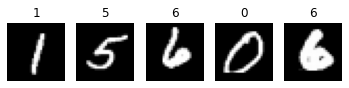

In [42]:
%matplotlib inline
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt

test_dir = 'mnist_png/testing'

test_data = datasets.ImageFolder(root=test_dir,
                            transform=transforms.Compose([
                            transforms.Grayscale(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))]))

raw_test_data = datasets.ImageFolder(root=test_dir,
                                        transform=transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.ToTensor()]))
num_samples = 5
indices = random.sample(range(len(raw_test_data) - 1), num_samples)
raw_images = np.array([raw_test_data[i][0].numpy() for i in indices])
raw_labels = np.array([raw_test_data[i][1] for i in indices])


for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(raw_images[i].reshape(28, 28), cmap='gray')
    plt.title(raw_labels[i])
    plt.axis('off')
    
images = np.array([test_data[i][0].numpy() for i in indices])

In [43]:
from sagemaker.pytorch.model import PyTorchPredictor

predictor = PyTorchPredictor(
        endpoint_name= mlworkflow_name
)

In [44]:
prediction = predictor.predict(images)
predicted_label = prediction.argmax(axis=1)

print('The GT labels are: {}'.format(raw_labels))
print('The predicted labels are: {}'.format(predicted_label))

The GT labels are: [1 5 6 0 6]
The predicted labels are: [1 5 6 0 6]


## [おまけ] Model Registry のモデルパッケージをデプロイ

以下のセルのコメントアウトを外してから実行すると、Model Registry に登録されたモデルパッケージを推論エンドポイントにデプロイすることができます。なお、モデルパッケージはステータスが Approved になっていないとデプロイできません。

モデルパッケージをエンドポイントにデプロイすると、Model Registry に記録されているモデルパッケージの Activity 情報に ModelDeployment というイベントが追加されます。

In [ ]:
# model_package_arn = model_package_list[0]['ModelPackageArn']
# tmp_endpoint_name = model_package_group_name + '-tmp'
# model_package = sagemaker.model.ModelPackage(role=role,
#                              model_package_arn=model_package_arn)
# model_package.deploy(instance_type='ml.m5.xlarge',
#                      initial_instance_count=1,
#                      endpoint_name=tmp_endpoint_name)
# package_predictor = PyTorchPredictor( endpoint_name= tmp_endpoint_name)

# prediction = package_predictor.predict(images)
# predicted_label = prediction.argmax(axis=1)

# print('The GT labels are: {}'.format(raw_labels))
# print('The predicted labels are: {}'.format(predicted_label))
# package_predictor.delete_endpoint()

## リソースの削除

このノートブックの実行が終わったら、不要なリソースを削除することを忘れないでください。このノートブックを最後まで実行してリソースの削除をしたら、ノートブックインスタンス、各種データを保存した S3 バケットも不要であれば削除してください。

### Amazon SageMaker 推論エンドポイントの削除

In [45]:
from sagemaker.pytorch.model import PyTorchPredictor

predictor = PyTorchPredictor(
        endpoint_name=mlworkflow_name
)
predictor.delete_endpoint()

### CodeCommit, CodeBuild, CodePipeline の削除

In [46]:
response = codecommit_client.delete_repository(
    repositoryName=code_repository_name
)
print('Delete:', response['repositoryId'])

response = codebuild_client.delete_project(
    name=codebuild_project_name
)
print('Delete:', codebuild_project_name)

response = codebuild_client.delete_project(
    name=codebuild_deploy_project_name
)
print('Delete:', codebuild_deploy_project_name)

response = codepipeline_client.delete_pipeline(
    name=codepipeline_name
)
print('Delete:', codepipeline_name)

Delete: c8c6c244-1c54-4557-9d49-f844dc6ab05f
Delete: mlops-pipeline-codebuild-sample2
Delete: mlops-pipeline-codebuild-deploy-sample2
Delete: mlops-pipeline-codepipeline-sample2


### Amazon ECR リポジトリの削除

In [47]:
container_image_list = [
    project_name + '-base-' + user_name,
    project_name + '-lambda-' + user_name,
    project_name + '-preprocess-' + user_name,
    project_name + '-train-' + user_name,
    project_name + '-evaluate-' + user_name,
]
for i in container_image_list:
    try:
        ecr_client.delete_repository(
            repositoryName=i,
            force=True
        )
        print('Delete:', i)
    except Exception as e:
        print(e)
        pass

Delete: mlops-pipeline-base-sample2
Delete: mlops-pipeline-lambda-sample2
Delete: mlops-pipeline-preprocess-sample2
Delete: mlops-pipeline-train-sample2
Delete: mlops-pipeline-evaluate-sample2


### Lambda 関数の削除

In [48]:
lambda_client.delete_function(FunctionName=postprocess_name)

{'ResponseMetadata': {'RequestId': '971e0c9d-7d72-45ff-b5be-0e4f72e3856d',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'date': 'Wed, 09 Feb 2022 09:56:13 GMT',
   'content-type': 'application/json',
   'connection': 'keep-alive',
   'x-amzn-requestid': '971e0c9d-7d72-45ff-b5be-0e4f72e3856d'},
  'RetryAttempts': 1}}

### Experiment の削除

In [49]:
sm = boto3.Session().client('sagemaker')
def cleanup(experiment):
    for trial_summary in experiment.list_trials():
        trial = Trial.load(sagemaker_boto_client=sm, trial_name=trial_summary.trial_name)
        for trial_component_summary in trial.list_trial_components():
            tc = TrialComponent.load(
                sagemaker_boto_client=sm,
                trial_component_name=trial_component_summary.trial_component_name)
            trial.remove_trial_component(tc)
            try:
                # comment out to keep trial components
                tc.delete()
            except:
                # tc is associated with another trial
                continue
            # to prevent throttling
            sleep(.5)
        trial.delete()
    experiment.delete()
    print('Delete:', experiment)
cleanup(experiment_evaluate)

Delete: Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f22cfc83550>,experiment_name='mlops-pipeline-exp-sample2',description='model evaluation',tags=None,experiment_arn='arn:aws:sagemaker:us-east-1:021269156472:experiment/mlops-pipeline-exp-sample2',response_metadata={'RequestId': 'fe8e405c-53e7-4d96-97ad-52f6e733bbde', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'fe8e405c-53e7-4d96-97ad-52f6e733bbde', 'content-type': 'application/x-amz-json-1.1', 'content-length': '98', 'date': 'Wed, 09 Feb 2022 09:56:15 GMT'}, 'RetryAttempts': 0})


### Amazon SageMaker Model Registry の削除

In [50]:
model_package_list = get_model_packages(model_package_group_name)
model_package_list = [{'ModelPackageArn': r['ModelPackageArn'],
                       'CreationTime': r['CreationTime'].astimezone(JST).strftime('%Y/%m/%d-%H:%M:%S'),
                       'ModelPackageVersion': r['ModelPackageVersion'],
                       'ModelApprovalStatus': r['ModelApprovalStatus']} for r in model_package_list] 

for m in model_package_list:
    response = sagemaker_client.delete_model_package(
        ModelPackageName=m['ModelPackageArn']
    )

response = sagemaker_client.delete_model_package_group(
    ModelPackageGroupName=model_package_group_name
)

### AWS Step Functions ワークフローの削除

In [51]:
workflow_list = Workflow.list_workflows()
workflow_arn = [d['stateMachineArn'] for d in workflow_list  if d['name']==mlworkflow_name][0]
sfn_workflow = Workflow.attach(workflow_arn)
try:
    sfn_workflow.delete()
    print('Delete:', mlworkflow_name)
except Exception as e:
    print(e)

Delete: mlops-pipeline-flow-sample2


### IAM Role と Policy の削除

In [52]:
role_name_list = list(set(role_name_list))
policy_arn_list = list(set(policy_arn_list))

response = iam_client.detach_role_policy(
    RoleName=role.split('/')[2],
    PolicyArn=sagemaker_policy_arn
)


for r in role_name_list:
    try:
        detach_role_policies(r)
        iam_client.delete_role(RoleName=r)
        print('Delete:', r)
    except Exception as e:
        print(e)
        continue

for p in policy_arn_list:
    try:
        iam_client.delete_policy(PolicyArn=p)
        print('Delete:', p)
    except Exception as e:
        print(e)
        continue

Delete: mlops-pipeline-codebuild-sample2-role
Delete: mlops-pipeline-codebuild-deploy-sample2-role
Delete: mlops-pipeline-post-sample2-role
Delete: mlops-pipeline-codepipeline-sample2-role
Delete: mlops-pipeline-read-metrics-sample2-role
Delete: mlops-pipeline-stepfunctions-sample2-role
Delete: arn:aws:iam::021269156472:policy/mlops-pipeline-read-metrics-sample2-policy
Delete: arn:aws:iam::021269156472:policy/mlops-pipeline-codebuild-deploy-sample2-policy
Delete: arn:aws:iam::021269156472:policy/mlops-pipeline-codebuild-sample2-policy
Delete: arn:aws:iam::021269156472:policy/mlops-pipeline-sample2-policy
Delete: arn:aws:iam::021269156472:policy/mlops-pipeline-post-sample2-policy
Delete: arn:aws:iam::021269156472:policy/mlops-pipeline-stepfunctions-sample2-policy
Delete: arn:aws:iam::021269156472:policy/mlops-pipeline-codepipeline-sample2-policy


### Amazon S3 バケットの削除
S3 バケットを削除したい場合は、以下のセルのコメントアウトを外してから実行してバケットを空にしてください。その後、コンソールからバケットの削除を実行してください。

In [53]:
# def delete_all_keys_v2(bucket, prefix, dryrun=False):
#     contents_count = 0
#     next_token = ''

#     while True:
#         if next_token == '':
#             response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)
#         else:
#             response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix, ContinuationToken=next_token)

#         if 'Contents' in response:
#             contents = response['Contents']
#             contents_count = contents_count + len(contents)
#             for content in contents:
#                 if not dryrun:
#                     print("Deleting: s3://" + bucket + "/" + content['Key'])
#                     s3_client.delete_object(Bucket=bucket, Key=content['Key'])
#                 else:
#                     print("DryRun: s3://" + bucket + "/" + content['Key'])

#         if 'NextContinuationToken' in response:
#             next_token = response['NextContinuationToken']
#         else:
#             break

#     print(contents_count, 'file were deleted.')

# delete_all_keys_v2(bucket_name, '')

Deleting: s3://mlops-pipeline-sample2-20220209-171141/build-log/b0656fee-749f-4fdd-b05f-b1f198e9aa5a.gz
Deleting: s3://mlops-pipeline-sample2-20220209-171141/build-log/ebee532a-160b-49be-af71-e0d4f9ed66e8.gz
Deleting: s3://mlops-pipeline-sample2-20220209-171141/data/PennFudanPed_Augmented/test.pt
Deleting: s3://mlops-pipeline-sample2-20220209-171141/data/PennFudanPed_Augmented/training.pt
Deleting: s3://mlops-pipeline-sample2-20220209-171141/evaluate/mlops-pipeline-flow-sample2-eval-202202091718/evaluation.json
Deleting: s3://mlops-pipeline-sample2-20220209-171141/mlops-pipeline-codep/Code/d6xzUIu
Deleting: s3://mlops-pipeline-sample2-20220209-171141/train/mlops-pipeline-flow-sample2-train-202202091718/output/model.tar.gz
7 file were deleted.
